**Oreum Industries Internal Project, 2024Q1**

---

### Oreum Copula Demo in `oreum_copula`

# 001_Demo_ModelA1

_**NOTE**
This is a direct copy of
[oreum_lab.101_CopulaModelA1.ipynb](https://github.com/oreum-industries/oreum_lab/blob/master/notebooks/101_CopulaModelA1.ipynb)
Brought here for convenience and so we can validate this version of packages etc
works for the basic copula model_


Build & test Model A1, an improved version of this architecture with a copula,
**but without a Jacobain adjustment**.

+ [x] **Construct model with Gaussian copula**
+ [ ] ~~Add Jacobian adjustment to handle the transformation of observeds~~


Full modelling workflow:

+ Create simple synthetic data
+ Construct model 
+ Sample prior predictive, evaluate parameter recovery and predictive ECDF
+ Sample posterior (and posterior predictive), evaluate sampling
+ Evaluate in-sample PPC via predictive ECDF
+ Manually calculate log-likelihood for potential
+ Evaluate in-sample PPC via LOO-PIT
+ Evaluate posterior parameter recovery
+ Replace with holdout dataset, create out-of-sample PPC
+ Evaluate out-of-sample PPC via predictive ECDF
+ Evaluate out-of-sample PPC numerically (Coverage, RMSE, R^2)

## Contents

+ [Setup](#Setup)

+ [1. Generate & Visualise Synthetic Dataset](#1.-Generate-&-Visualise-Synthetic-Dataset)

+ [2. Define & Build Model, Sample Prior & Evaluate](#2.-Define-&-Build-Model-&-Sample-Prior-&-Evaluate)

+ [3. Sample Posterior & Evaluate](#3.-Sample-Posterior-&-Evaluate)

+ [4. Evaluate Posterior Parameters](#4.-Evaluate-Posterior-Parameters)

+ [5. Predict Out-of-Sample (Holdout Set)](#5.-Predict-Out-of-Sample-(Holdout-Set))

+ [6. Evaluate Predictions (Holdout Set)](#6.-Evaluate-Predictions-(Holdout-Set))


---

# Setup

## Imports

In [1]:
import sys
from copy import deepcopy
from pathlib import Path

import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from pyprojroot.here import here

module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))

# autoreload local modules to allow dev-js
%load_ext autoreload
%autoreload 2
from oreum_core import eda
from oreum_core import model_pymc as mt

# from engine import app_logger
from engine.trainer import Trainer
from model.model_a import ModelA1
from synthetic.create_copula import CopulaBuilder

import warnings  # isort:skip
warnings.simplefilter(action='ignore', category=FutureWarning)  # isort:skip

##### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='darkgrid', palette='muted', context='notebook', 
        rc={'savefig.dpi':300, 'figure.figsize': (12, 3)})

# log = app_logger.get_logger('001_Example_ModelA1', notebook=True)
# _ = app_logger.get_logger('oreum_core', notebook=True)
# # _ = app_logger.get_logger('py.warnings', notebook=True)

## Local Functions and Global Vars

In [3]:
RELOAD_IDATA = False
RSD = 42
rng = np.random.default_rng(seed=RSD)

## Data Connections

In [4]:
fqp_plots = here(Path('plots')).resolve(strict=True)
figio = eda.FigureIO(rootdir=fqp_plots)

---

---

# 1. Generate & Visualise Synthetic Dataset

## 1.1 Create Synthetic Copula Dataset

Create synthetic copula dataset using a "forward-pass":

1. Start at copula (`c0, c1`) ->
2. Transform to uniform (`u0, u1`) ->
3. Transform to marginals (`m0, m1`)
4. Also for comparison, create marginals (`m0x`, `m1x`) without copula

Also note, now we create $120$ observations split into 2 sets: $100$ for `train` (in-sample) and $20$ for `holdout` (out-of-sample)

In [5]:
cb = CopulaBuilder()
df_all = cb.create(nobs=120)
cb.ref_vals

{'c_r': -0.7,
 'c_cov': array([[ 1. , -0.7],
        [-0.7,  1. ]]),
 'm0_kind': 'lognorm',
 'm1_kind': 'lognorm',
 'm0_params': {'mu': 0.2, 'sigma': 0.5},
 'm1_params': {'mu': 2.0, 'sigma': 1.0}}

In [6]:
perm = rng.permutation(df_all.index.values)
df_train = df_all.loc[perm[:100]]
df_holdout = df_all.loc[perm[100:]]

**Note:** 

+ For marginals `m0` and `m1`, we label the value as `mu`, but this is actually exponentiated prior to creating the lognormal marginal. E.g. `LogNormal(mu=exp(mu), sigma=sigma)`

In [7]:
eda.describe(df_train, nobs=0, get_counts=False)

dtype      sum      mean    std       min    25%       50%    75%  \
ft                                                                           
index    int64  6142.00  6.14e+01  34.68  0.00e+00  31.75  6.15e+01  90.25   
c0     float64     0.75  7.48e-03   0.90 -2.28e+00  -0.65  3.18e-03   0.63   
c1     float64    -1.49 -1.49e-02   1.00 -2.30e+00  -0.64  7.05e-05   0.63   
u0     float64    50.37  5.04e-01   0.27  1.13e-02   0.26  5.01e-01   0.74   
u1     float64    49.52  4.95e-01   0.29  1.06e-02   0.26  5.00e-01   0.73   
m0     float64   135.21  1.35e+00   0.62  3.91e-01   0.88  1.22e+00   1.67   
m1     float64  1271.09  1.27e+01  21.48  7.39e-01   3.91  7.39e+00  13.81   
u0x    float64    49.66  4.97e-01   0.29  2.11e-02   0.25  5.09e-01   0.75   
u1x    float64    47.41  4.74e-01   0.30  5.43e-03   0.20  4.56e-01   0.74   
m0x    float64   134.45  1.34e+00   0.62  4.43e-01   0.86  1.24e+00   1.72   
m1x    float64  1090.60  1.09e+01  12.11  5.79e-01   3.15  6.62e+00  13.94   

          max  
ft             
index  119.00  
c0       2.07  
c1       3.05  
u0       0.98  
u1       1.00  
m0       3.44  
m1     155.69  
u0x      0.98  
u1x      0.99  
m0x      3.40  
m1x     67.72

'Shape: (100, 11), Memsize 0.0 MB'

## 1.2 Visualise the Synthetic Observations

### 1.2.1 View the Copula (an MvN)

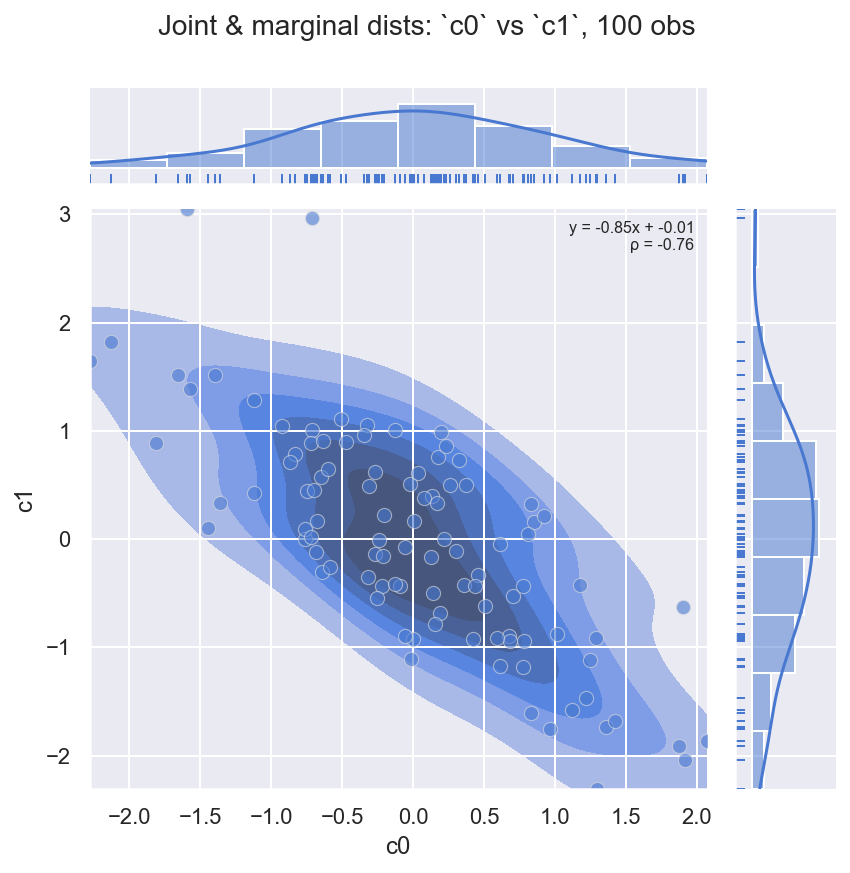

In [8]:
f = eda.plot_joint_numeric(data=df_train, ft0='c0', ft1='c1', kind='kde+scatter', 
            subtitle=f'Latent Copula = $MvN(0, \Sigma={cb.ref_vals["c_cov"].flatten().tolist()})$')

**Observe:**

+ Note the standard `Normal(0,1)` scaling on the marginals
+ Note the empirically-observed $\rho \approx -0.7$ as defined

### 1.2.2 View the Uniform-Transformed Marginals

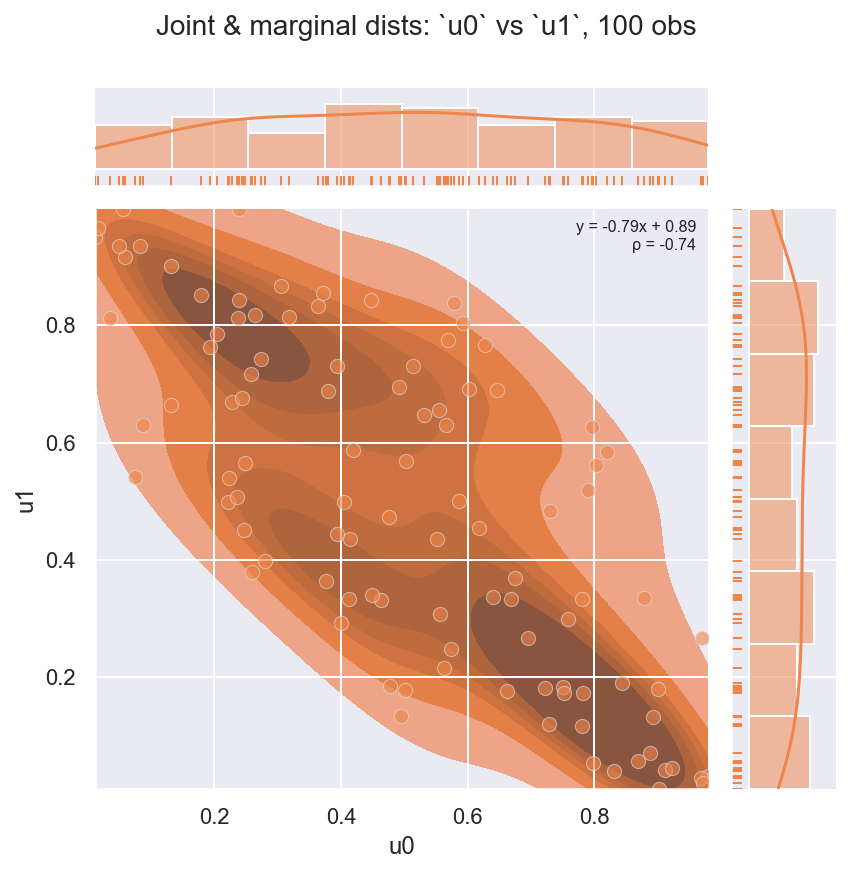

In [9]:
f = eda.plot_joint_numeric(data=df_train, ft0='u0', ft1='u1', kind='kde+scatter', colori=1, 
        subtitle='Latent Uniform Marginals with Copula Correlation')

### 1.2.3 View the Observed Marginals `m0`, `m1` (post transformation)

**Observe:**

+ This is the only real data that we would observe in the real-world dataset
+ All the other datapoints are latent
+ We compare this data to the model predictions (in-sample PPC)

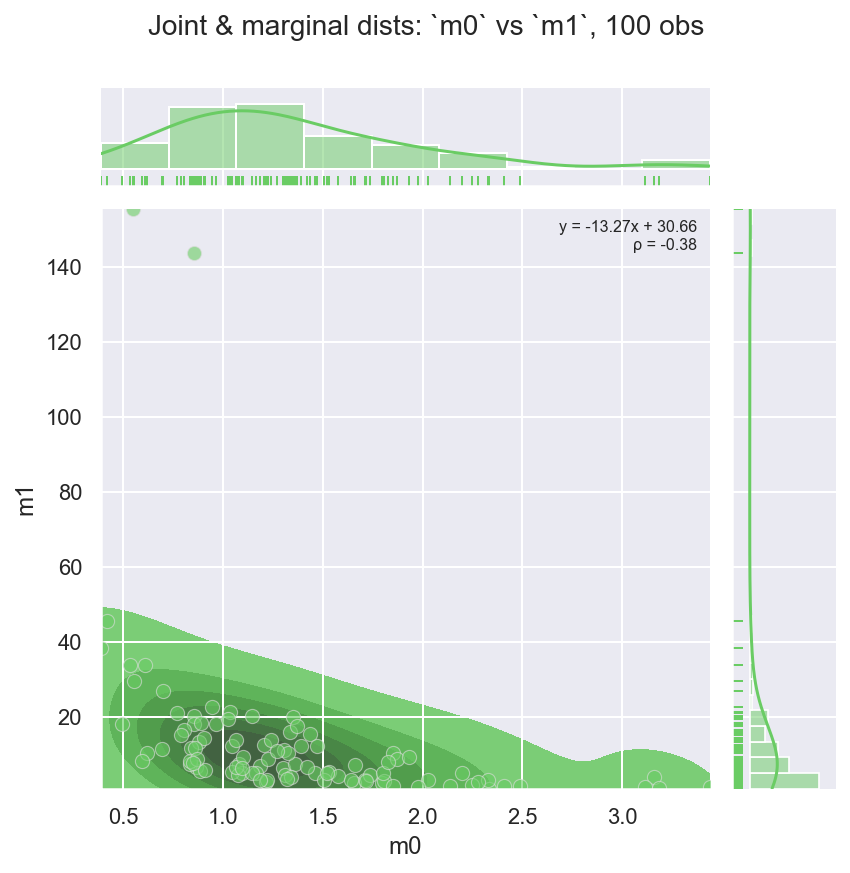

In [10]:
f = eda.plot_joint_numeric(data=df_train, ft0='m0', ft1='m1', kind='kde+scatter', colori=2, 
            subtitle='Observed Marginals with Copula Correlation')

**Observe**

+ Marginals have covariant joint distribution

### 1.2.4 View the Uncorrelated marginals `m0x`, `m1x` (ignoring copula)

#### Observed Marginals (uncorrelated)

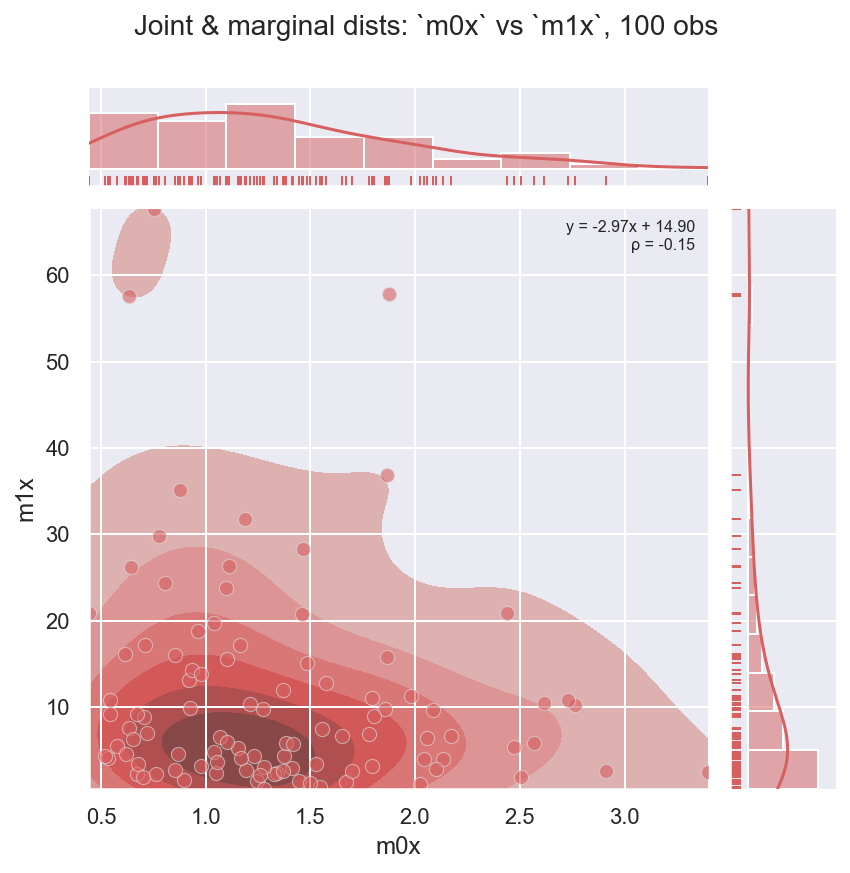

In [11]:
f = eda.plot_joint_numeric(data=df_train, ft0='m0x', ft1='m1x', kind='kde+scatter', colori=3, 
            subtitle='Observed Marginals without Copula Correlation')

**Observe**

+ Spherical joint distribution, no correlation between our marginals here

### 1.2.5 Overplot Correlated and Uncorrelated Marginals to highlight differences

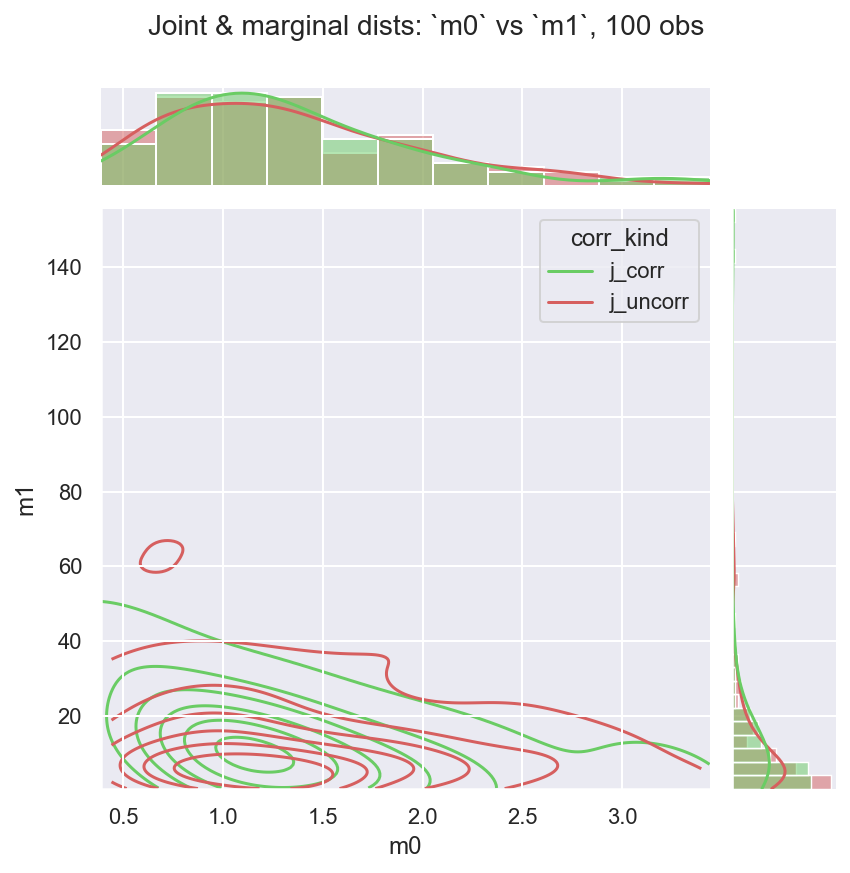

In [12]:
dfp = pd.concat((df_train[['m0', 'm1']], df_train[['m0x', 'm1x']]\
                 .rename(columns={'m0x':'m0', 'm1x': 'm1'})),
                axis=0, ignore_index=True)
dfp['corr_kind'] = np.repeat(['j_corr', 'j_uncorr'], repeats=len(df_train))
f = eda.plot_joint_numeric(
    data=dfp, ft0='m0', ft1='m1', hue='corr_kind', kind='kde', kdefill=False, colori=2,
    subtitle='Observed marginals with / without Copula Correlation')

**Observe**

+ The marginals look almost identical
+ But the joint distribution is very different: correlated green vs spherical (non-corrolated) red
+ This leads to a very different Expected Value

### 1.2.6 Compare the Impact on Joint Distribution

If we fail to model the correlation, the impact on the joint distribution is substantial, and we might easily under/over estimate an Expected value

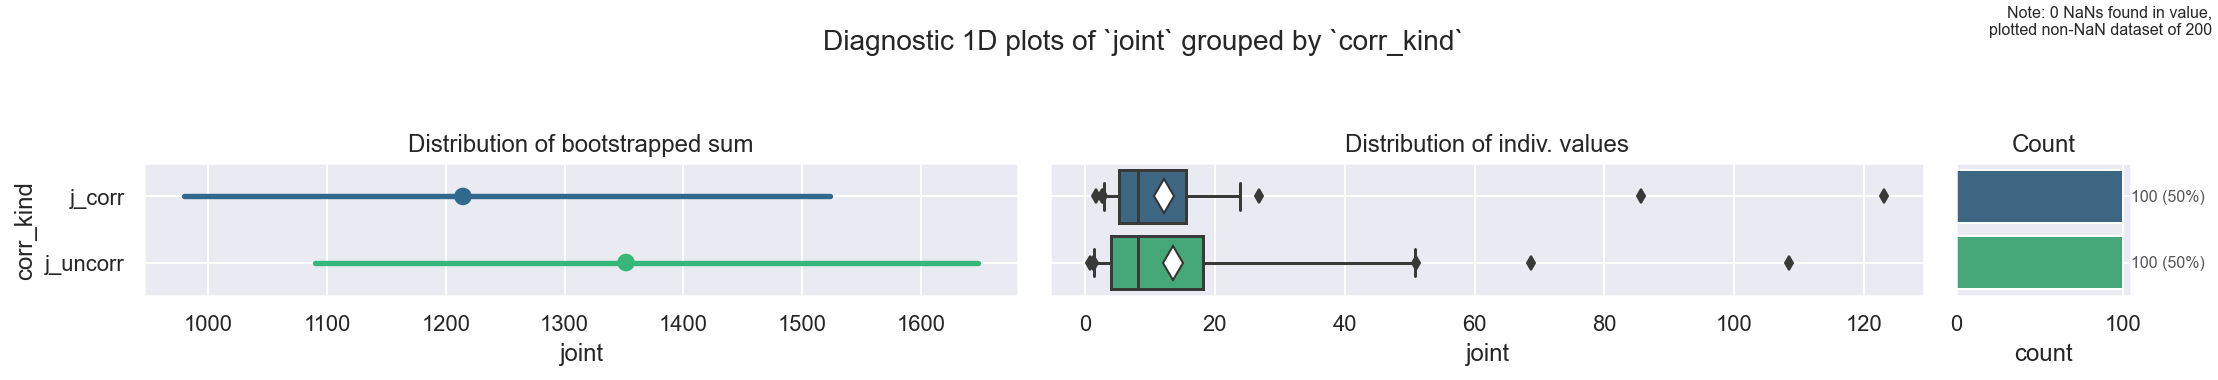

In [13]:
dfp['joint'] = dfp[['m0', 'm1']].product(axis=1)
pal = sns.color_palette(['C2', 'C3'])
f = eda.plot_smrystat_grp(dfp, grp='corr_kind', val='joint', palette=pal)

**Observe:**

+ The (bootstrapped) sum of `j_uncorr` ($\mu \approx 1350$) is always much higher than for `j_corr` ($\mu \approx 1200$)
+ This shows that even if we estimated each marginal correctly, if our model were to (erroroneously) ignore the coupled covariance between our marginals `m0`, `m1`, we would (erroneously) overestimate the joint distribution total value

#### View the delta

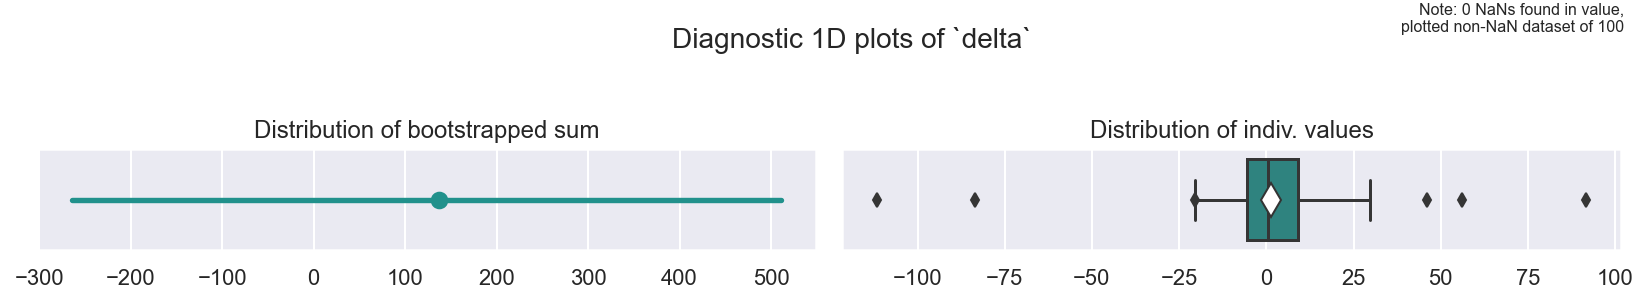

In [14]:
idx = dfp['corr_kind'] == 'j_corr'
dfpp = pd.DataFrame({'delta': dfp.loc[~idx, 'joint'].values - dfp.loc[idx, 'joint'].values}, index=df_train.index)
g = eda.plot_smrystat(dfpp, val='delta', title_add='joint expected value')

**Observe:**

+ Here we view `delta = j_uncorr - j_corr`
+ If we imagine this to be a portfolio of $100$ policies, and the value of interest is an Expected Loss Cost $\text{E}_{loss}$, and the units are dollars, then: 
  + Without the copula, the estimate of $\text{E}_{loss}$ (bootstrapped mean) sum over the portfolio is approx $130$ dollars *higher* than if we use a better model with a copula function
  + This overestimate is a substantial ($\frac{130}{1200} \approx +10\%$) and could make the difference between profitable pricing and accurate reserving, or greatly loss-making business over the portfolio.

## 1.3 Transform observations for linear sub-models

Normally, we would use `patsy` to transform the "raw" (synthetic) data created above into two separate design-matrices (for marginal 1 and marginal 2) each according to a linear model. This is total overkill here, so we'll keep life much simpler.

We have no features for `m0` and `m1`, so the linear sub-models have to be intercept-only. Here we must also forget anything we know about the construction of the synthetic data, this is all we have.

### 1.3.1 Train set (in-sample)

In [15]:
eda.describe(df_train[['m0', 'm1']])

8     77     65    dtype  count_null  count_inf  count_zero  \
ft                                                                      
index  0.00  23.00   1.00    int64           0          0           1   
m0     0.87   0.85   1.04  float64           0          0           0   
m1     6.54  17.99  21.25  float64           0          0           0   

           sum   mean    std   min    25%    50%    75%     max  
ft                                                               
index  6142.00  61.42  34.68  0.00  31.75  61.50  90.25  119.00  
m0      135.21   1.35   0.62  0.39   0.88   1.22   1.67    3.44  
m1     1271.09  12.71  21.48  0.74   3.91   7.39  13.81  155.69

'Shape: (100, 3), Memsize 0.0 MB'

In [16]:
dfx_m0_train = df_train[['m0']].copy()
dfx_m0_train['intercept'] = 1.0
eda.display_ht(dfx_m0_train)

m0  intercept
2   2.33        1.0
46  1.46        1.0
37  1.31        1.0
54  0.59        1.0
49  0.85        1.0
6   1.47        1.0

'Shape: (100, 2), Memsize 0.0 MB'

In [17]:
dfx_m1_train = df_train[['m1']].copy()
dfx_m1_train['intercept'] = 1.0
eda.display_ht(dfx_m1_train)

m1  intercept
2    0.74        1.0
46   4.85        1.0
37  11.01        1.0
54   8.21        1.0
49   7.52        1.0
6   12.15        1.0

'Shape: (100, 2), Memsize 0.0 MB'

### 1.3.2 holdout set (out-of-sample)

In [18]:
eda.describe(df_holdout[['m0', 'm1']])

8      8     17    dtype  count_null  count_inf  count_zero  \
ft                                                                       
index  47.00  47.00  65.00    int64           0          0           0   
m0      2.01   2.01   1.12  float64           0          0           0   
m1      0.89   0.89   3.03  float64           0          0           0   

          sum   mean    std   min    25%    50%    75%     max  
ft                                                              
index  998.00  49.90  34.56  8.00  17.75  44.00  68.75  108.00  
m0      28.44   1.42   0.41  0.67   1.11   1.38   1.76    2.05  
m1     150.96   7.55   6.25  0.89   2.82   4.50  12.33   21.48

'Shape: (20, 3), Memsize 0.0 MB'

In [19]:
dfx_m0_holdout = df_holdout[['m0']].copy()
dfx_m0_holdout['intercept'] = 1.0

In [20]:
dfx_m1_holdout = df_holdout[['m1']].copy()
dfx_m1_holdout['intercept'] = 1.0

---

---

# 2. Define & Build Model, Sample Prior & Evaluate

## 2.0 Model Spec

### Estimate Marginals

#### M0

\begin{align}
    \beta_{m0}^{j1} &\sim \text{Normal}(\mu, \sigma) \\
    \sigma_{m0} &\sim \text{InverseGamma}(\alpha, \beta) \\
    \mathfrak{m0}_{y}^{j0} &\sim \text{LogNormal}(\mu=\beta_{m0}^{T}\vec{x}_{y}^{j0}, \sigma=\sigma_{m0}) \\
\end{align}


#### M1

\begin{align}
    \beta_{m1}^{j1} &\sim \text{Normal}(\mu, \sigma) \\
    \sigma_{m1} &\sim \text{InverseGamma}(\alpha, \beta) \\
    \mathfrak{m1}_{y}^{j1} &\sim \text{LogNormal}(\mu=\beta_{m1}^{T}\vec{x}_{y}^{j1}, \sigma=\sigma_{m1}) \\
\end{align}

Where:

+ We use the same distribution family for each marginal (a LogNormal), 
  because we want to keep this example simple
+ We indicate and observations as $y$ e.g. $\vec{x}_{y}^{j0}$
+ The linear models for the regression on each LogNormal marginal are exponentiated 
  for convenience, so that $\beta_{m}^{T}\vec{x}^{j}$ becomes the median value
+ Features in $\vec{x}^{j1}$ and $\vec{x}^{j2}$ are each chosen from the full 
  set of features $j \in m$
+ In our synthetic data here, we actually have no features $m$, so $j0$ and $j1$
  are both intercept-only






### Estimate Copula

1. Transform marginals to uniform via their CDFs:
\begin{align}
    \mathbf{u0}_{y} &= \mathfrak{m0}_{y}\Phi(\mathbf{m0}_{y}) \\
    \mathbf{u1}_{y} &= \mathfrak{m1}_{y}\Phi(\mathbf{m1}_{y})
\end{align}


2. Transform the uniform marginals to our MvN copula via a standard Normal 
   (or equivalently MvN without covariance) InvCDF
\begin{align}
    (\mathbf{c0}, \mathbf{c1})_{y} &= \text{MvNormal}(\mu=0, \sigma=1)\Phi^{-1}([\mathbf{u0}_{y}, \mathbf{u1}_{y}])
\end{align}

3. Create covariance structure for our MvN copula

\begin{align}
    L &\sim \text{LKJCholesky}(2), \; R \sim \text{LKJCorr}(2) \\
    \sigma &\sim \text{InverseGamma}(\alpha, \beta) \\
    \Sigma &\sim LL^{T} = diag(\sigma) * R * diag(\sigma)
\end{align}

4. Evaluate likelihood of the transformed marginals at our covarying copula:

\begin{align}
    copula &\sim \text{MvNormal}(\mu=0, \Sigma, observed=(\mathbf{c0}, \mathbf{c1})_{y}
\end{align}


#### 2.0.1 Build helper objects

In [21]:
fqns = dict(
    fp_mdl=here(Path('data', 'models', 'mdla')).resolve(strict=True),
    fp_plots = here(Path('plots')).resolve(strict=True),
    fn_mdl='idata_mdla1.netcdf',
)
trainer = Trainer(fqns=fqns)

#### 2.0.2 Sanity-check Lognorm Implementations `scipy` vs `pymc`

In [22]:
mt.sanity_check_lognorm(cb.ref_vals['m0_params']['mu'], 
                        cb.ref_vals['m1_params']['sigma'])

## 2.1 Build Model Object

**NOTE:** Model imported from `src.model.copula.model_a.py` where it is fully defined

In [23]:
mdl = ModelA1(obs_m0=dfx_m0_train, obs_m1=dfx_m1_train)
mdl.build()
_ = [display(Markdown(s)) for s in mt.print_rvs(mdl)]

m0_b ~ Normal(0, 1)

m1_b ~ Normal(0, 1)

m_s ~ InverseGamma(5, 4)

lkjcc ~ _lkjcholeskycov(2, 2, InverseGamma(5, 4))

pot_yhat ~ Potential(f(m_s, m1_b, m0_b))

pot_c ~ Potential(f(lkjcc, m_s, m1_b, m0_b))

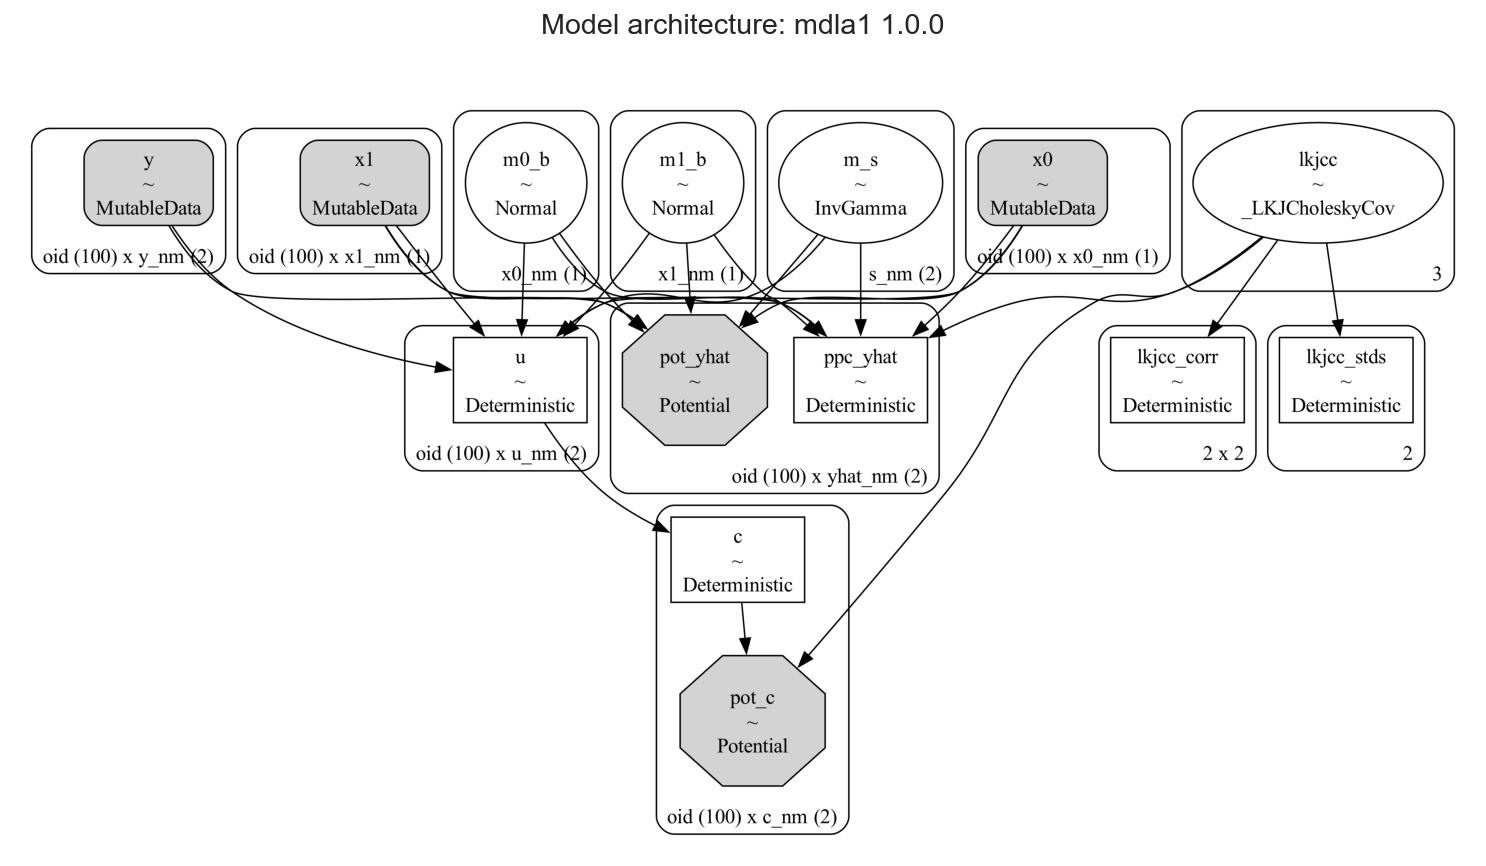

In [24]:
fqn = trainer.mdlio.write_graph(mdl)  # output model graph to prove built
f = eda.display_image_file(fqn, 
    title=f'Model architecture: {mdl.name} {mdl.version}', figsize=(12, 6))

##### Quick pass with [`model.debug()`](https://github.com/pymc-devs/pymc/blob/5f29b255127088abc552079fd03c40eb19d83bdd/pymc/model/core.py#L1739) and [`pymc.testing.assert_no_rvs`](https://github.com/pymc-devs/pymc/blob/c3f93bad3db7c34c12e4c51e1e7fb88f62c97020/pymc/testing.py#L952)

In [25]:
print('Random:\n')
mdl.model.debug(fn='random', verbose=True)

# known failure for potentials: https://github.com/pymc-devs/pymc/issues/6966
# print('logP:\n')
# mdl.model.debug(fn='logp', verbose=True)

from pymc.testing import assert_no_rvs

assert_no_rvs(mdl.model.logp())

Random:

point={'m0_b': array([0.]), 'm1_b': array([0.]), 'm_s_log__': array([0., 0.]), 'lkjcc_cholesky-cov-packed__': array([0., 0., 0.])}

No problems found


## 2.2 Sample Prior Predictive & Evaluate

In [26]:
mdl.sample_prior_predictive(var_names=mdl.rvs_unobs + mdl.rvs_det + mdl.rvs_ppc, 
                            replace=True)

## correct for sample_prior_predictive not putting the right things in the right places!

# 1. create observed_data 
# TypeError: `data` argument must have the group "observed_data" for ppcplot
if 'observed_data' not in mdl.idata.groups():
    mdl.idata.add_groups(
        observed_data=deepcopy(
            (mdl.idata.constant_data
            .rename_vars({'y': 'yhat'})
            .drop_vars(['y_nm'])
            .swap_dims({'y_nm': 'yhat_nm'})
            .assign_coords({'yhat_nm': ['yhat0', 'yhat1']})
            .drop_vars(['x0', 'x1'])
            .drop_dims(['x0_nm', 'x1_nm'])
            )))

# 2. move yhat from prior to prior_predictive 
#   TypeError: `data` argument must have the group "prior_predictive" for ppcplot
if 'prior_predictive' not in mdl.idata.groups():
    mdl.idata.add_groups(prior_predictive=deepcopy(
        (mdl.idata.prior
         .drop_vars(mdl.rvs_unobs + mdl.rvs_det)
         .drop_dims([
            'x0_nm', 'x1_nm', 's_nm', 'u_nm', 'c_nm',
            'lkjcc_dim_0', 'lkjcc_corr_dim_0', 'lkjcc_corr_dim_1', 'lkjcc_stds_dim_0'
            ])
         )))
        
mdl.idata

/Users/jon/workspace/oreum/oreum_core/oreum_core/model_pymc/base.py:147: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_pred = pm.sample_prior_predictive(**{**kws, **kwargs})
/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

### 2.2.1 Hyperpriors on Marginals for Feature Regression

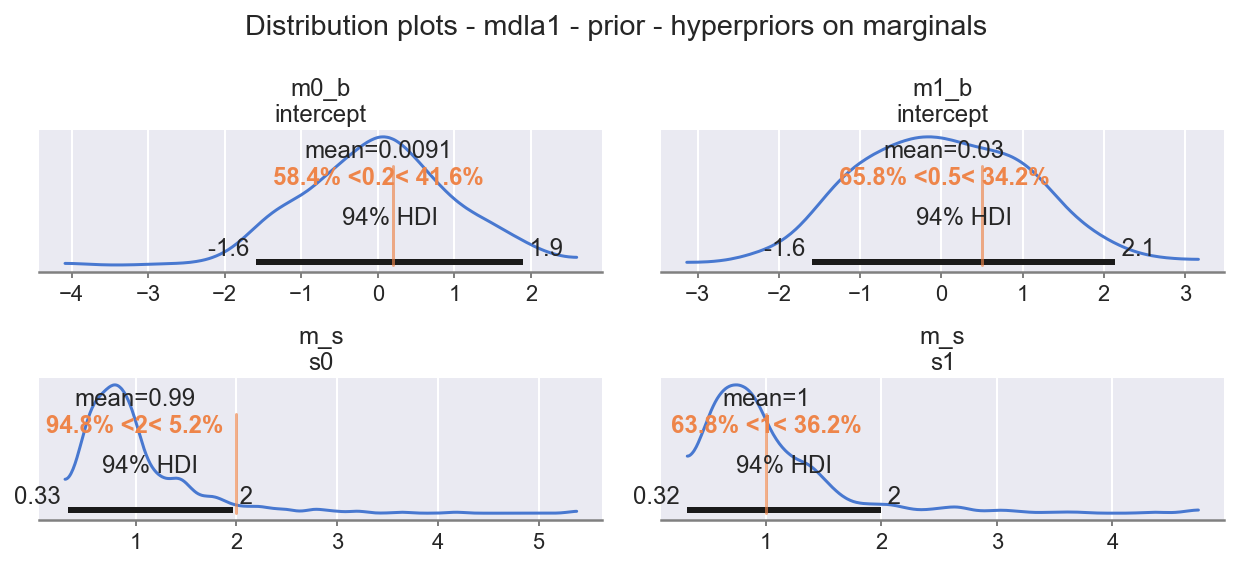

In [27]:
# get ref values from copula builder
refs = [cb.ref_vals['m0_params']['mu'], cb.ref_vals['m0_params']['sigma'], 
        cb.ref_vals['m1_params']['mu'], cb.ref_vals['m1_params']['sigma']
        ]
f = mt.facetplot_krushke(mdl=mdl, group='prior', txtadd='hyperpriors on marginals',
        rvs=mdl.rvs_marg, ref_vals=refs, m=2)

**Observe:**

+ Priors contain the reference values, seems reasonable

### 2.2.2 Copula Structure

#### 2.2.2.1 LKJCholeskyCov (decomposition and stds)

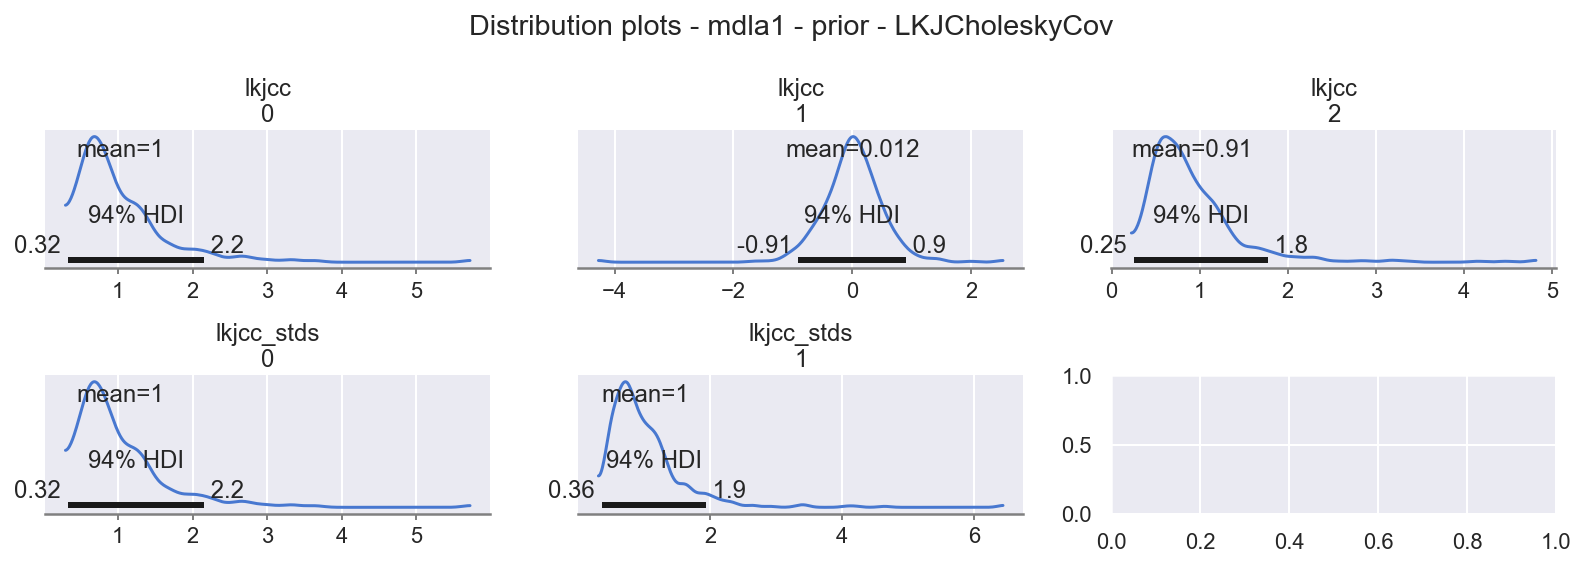

In [28]:
f = mt.facetplot_krushke(mdl=mdl, group='prior', txtadd='LKJCholeskyCov',
        rvs=mdl.rvs_lkjcc, m=3)

#### 2.2.2.2 LKJCholeskyCov (Correlation Matrix)

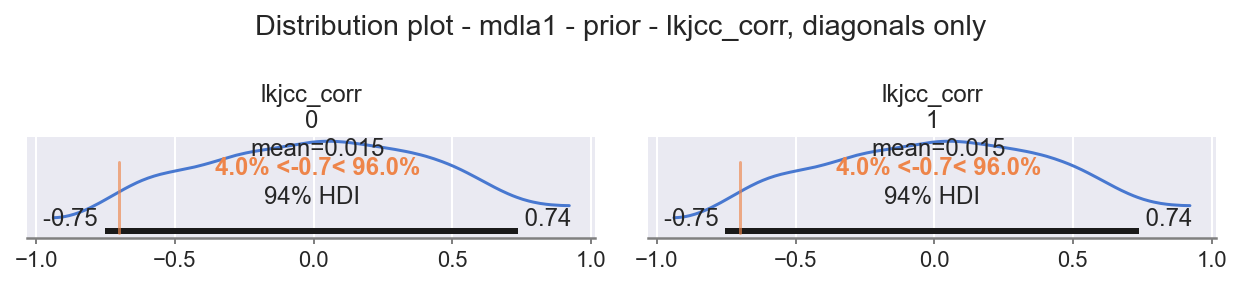

In [29]:
f = mt.plot_lkjcc_corr(mdl=mdl, group='prior', ref_vals=2*[cb.ref_vals['c_r']])

**Observe:**

+ Priors contain the reference values, seems reasonable

#### 2.2.2.3 Check `u0`, `u1` (post-transformation Marginal -> (marginal_dist.CDF) -> Uniform)

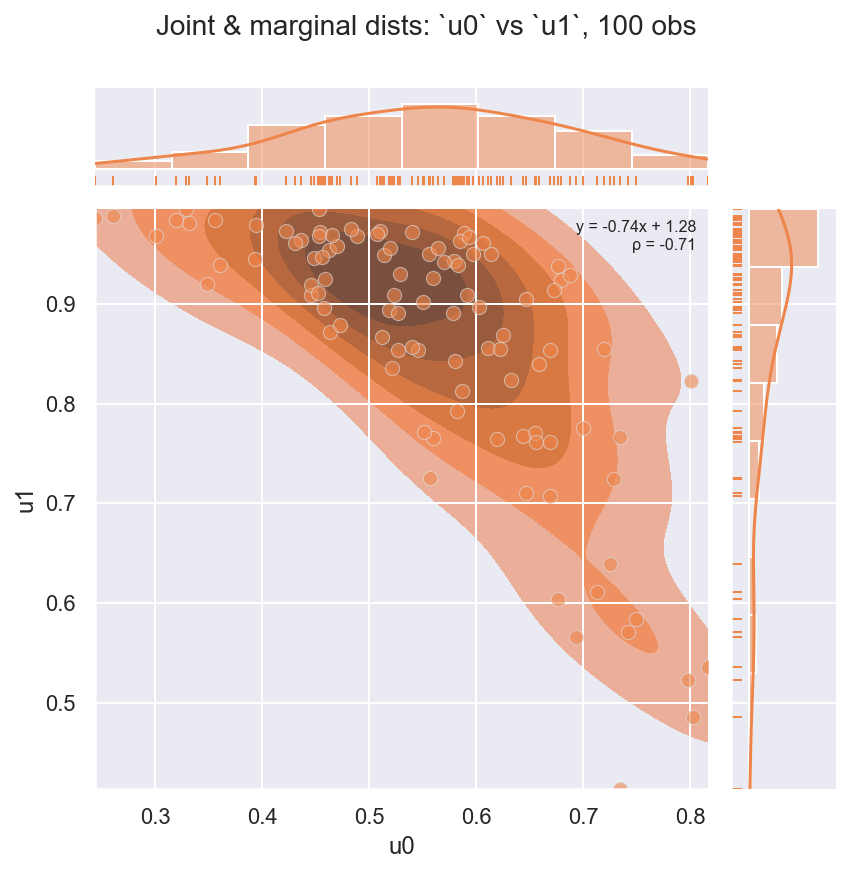

In [30]:
rv = 'u'
cols = mdl.coords[f'{rv}_nm']
x = az.extract(mdl.idata, group='prior', var_names=rv).values
dfp_u = pd.DataFrame(np.nanmean(x, axis=2), columns=cols)
f = eda.plot_joint_numeric(data=dfp_u, ft0=cols[0], ft1=cols[1], kind='kde+scatter', 
            colori=1, subtitle='Prior Predictive Latent Uniform Marginals (mean)')

**Observe**

+ RVs are in the right range [0,1]
+ You can see the skew already generated by the underlying marginal priors

#### 2.2.2.4 Check `c1`, `c2` (post-transformation Uniform -> (normal.invCDF) -> MvN)

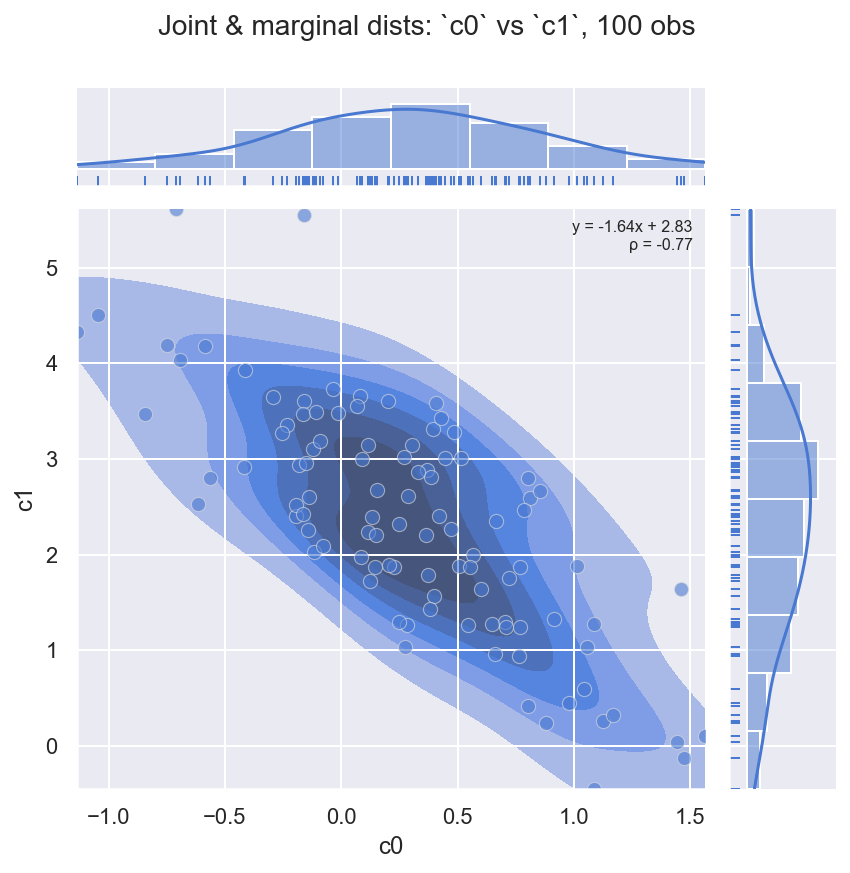

In [31]:
rv = 'c'
cols = mdl.coords[f'{rv}_nm']
x = az.extract(mdl.idata, group='prior', var_names=rv).values
dfp_y_u = pd.DataFrame(np.nanmean(x, axis=2), columns=cols)
f = eda.plot_joint_numeric(data=dfp_y_u, ft0=cols[0], ft1=cols[1], kind='kde+scatter', 
            subtitle='Prior Predictive Latent Copula (mean)')

**Observe**

+ Looks reasonable and similar to the original synthetic data that we created above: 
  + negative correlation and similar ranges
  + different mean-centering
+ Note the empirically-observed $\rho \approx -0.7$ as defined

##### 2.2.2.4.2 Percentiles across samples

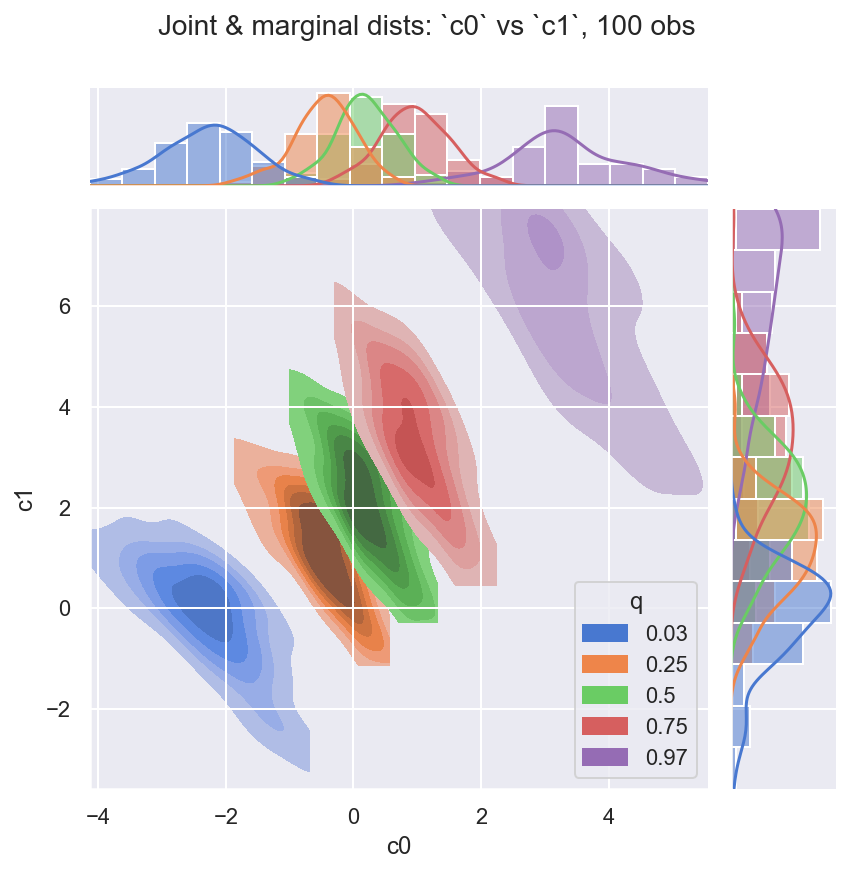

In [32]:
qs = [0.03, 0.25, 0.5, 0.75, 0.97]
dfp_c_q = pd.DataFrame(np.quantile(x, qs, axis=2).reshape(len(qs)*mdl.n, 2), columns=cols)
dfp_c_q['q'] = np.repeat([f'{q}'  for q in qs], mdl.n)
f = eda.plot_joint_numeric(data=dfp_c_q, ft0=cols[0], ft1=cols[1], hue='q', kind='kde',
            legendpos='lower right',
            subtitle='Prior Predictive Latent Copula (by quantile)')

**Observe:**

+ Covering a lot of the space: seems reasonable and not overly informative

### 2.2.3 Plot ECDF

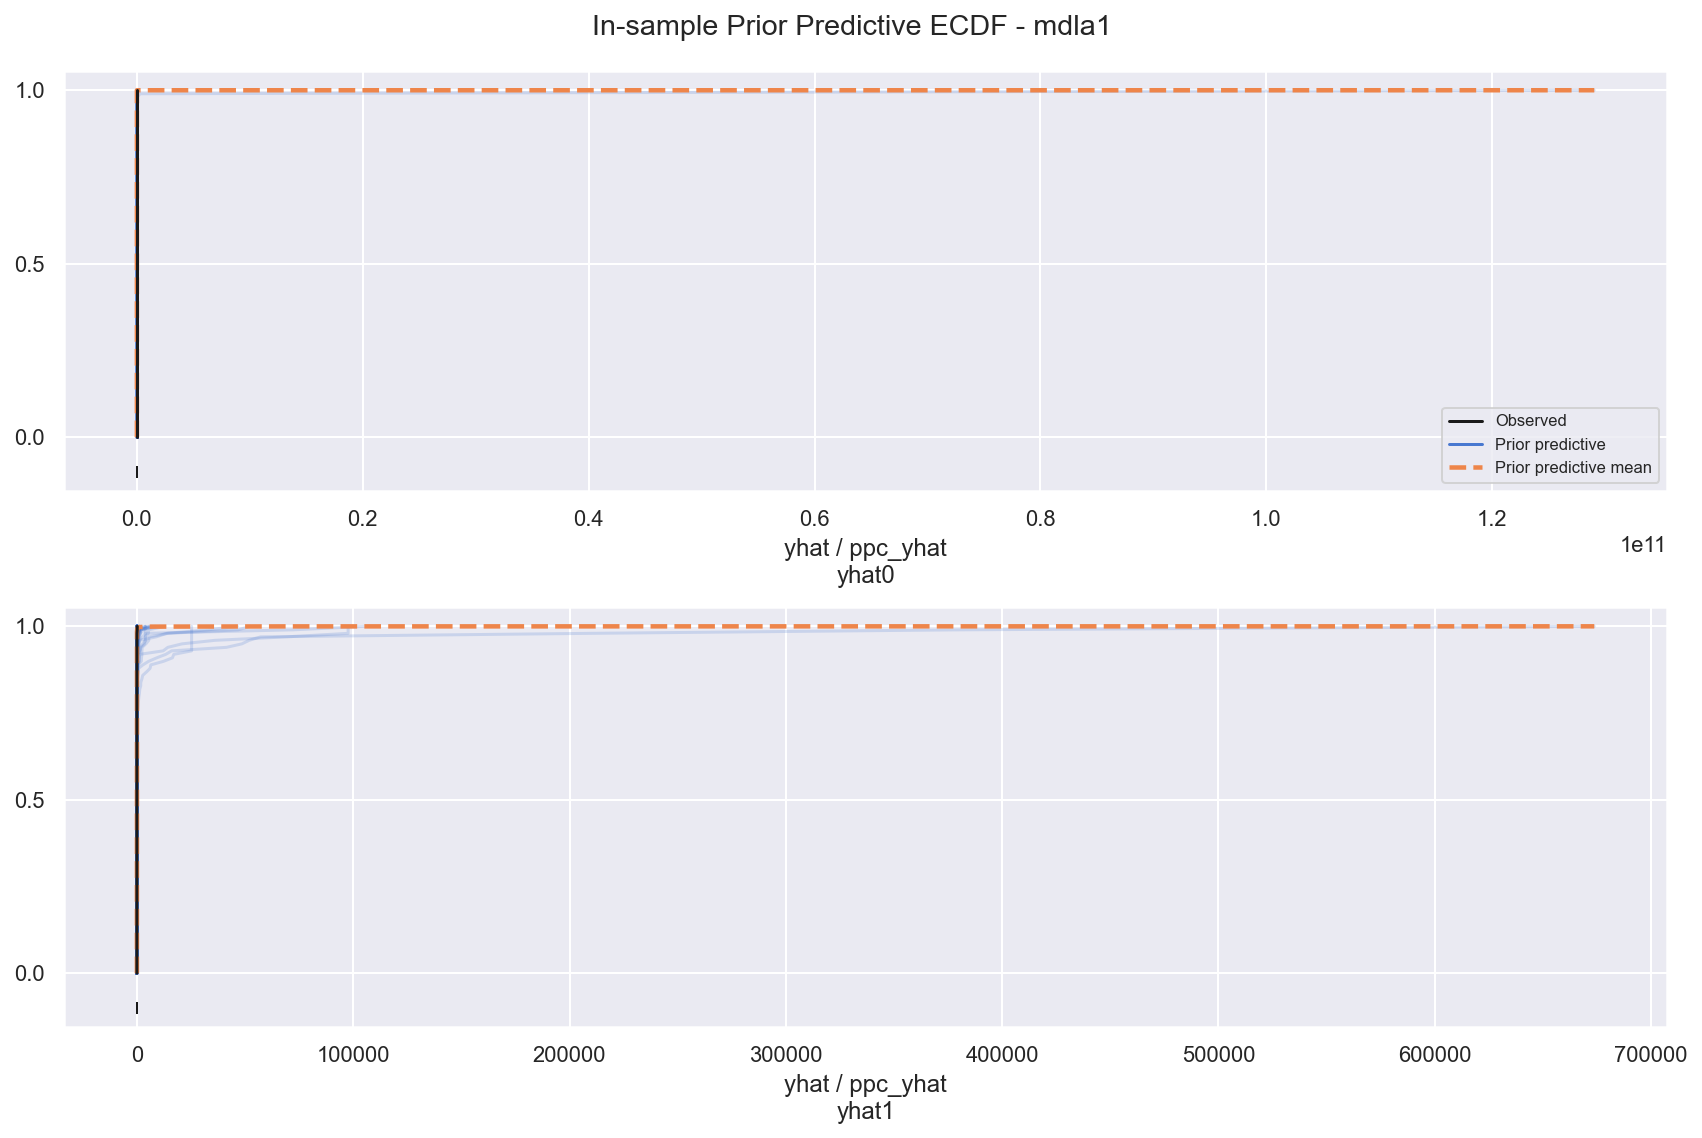

In [33]:
_ = mt.plot_ppc(mdl, group='prior', data_pairs={'yhat':'ppc_yhat'}, 
                flatten=['oid'], observed_rug=True)

**Observe:**

+ Terrible fit as expected, but the range is valid

---

---

# 3. Sample Posterior & Evaluate

## 3.1 Sample Posterior

In [34]:
if RELOAD_IDATA:
    mdl.update_idata(trainer.mdlio.read_idata(fqn=trainer.fqns['fqn_idata']))
else:
    mdl.sample()
    mdl.sample_posterior_predictive(store_ppc=True, ppc_insample=True, 
                                    var_names=mdl.rvs_ppc)
    trainer.mdlio.write_idata(mdl=mdl)

mdl.idata

/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op erfcinv does not provide a C

/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op erfcinv does not provide a C

/Users/jon/workspace/oreum/oreum_core/oreum_core/model_pymc/base.py:230: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(**{**kws, **kwargs})
/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

## 3.2 View Diagnostics

### 3.2.1 Plot Posterior Traces

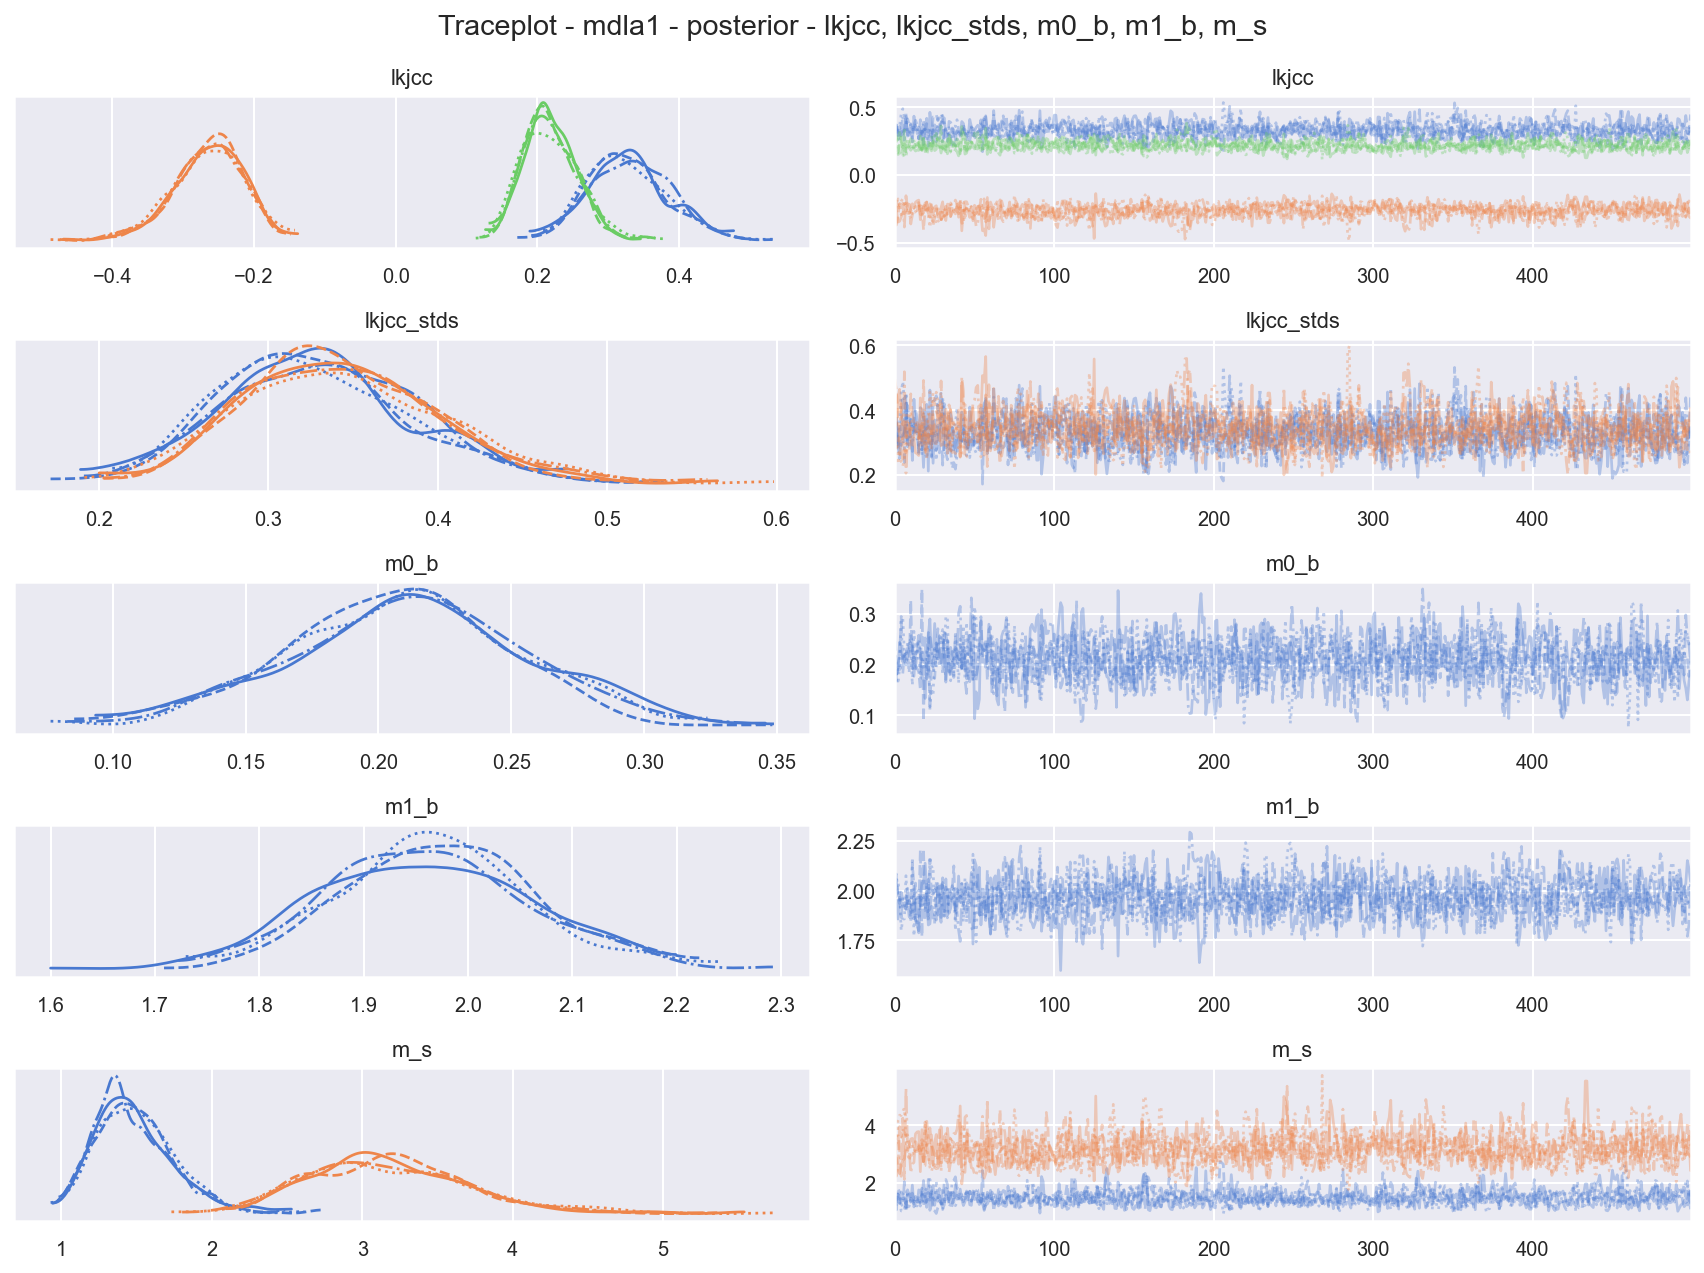

In [35]:
f = mt.plot_trace(mdl=mdl, rvs=mdl.rvs_lkjcc + mdl.rvs_marg, kind='trace')

**Observe:**
    
+ Traces appear reasonably well-mixed
+ Posterior distributions reasonably central

### 3.2.2 Summarize Posterior

In [36]:
mt.get_summary(mdl=mdl, rvs=mdl.rvs_unobs)

/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lkjcc[0]          0.328  0.056   0.233    0.441      0.002    0.001    1228.0   
lkjcc[1]         -0.265  0.050  -0.362   -0.177      0.001    0.001    1156.0   
lkjcc[2]          0.218  0.039   0.151    0.290      0.001    0.001    1062.0   
lkjcc_stds[0]     0.328  0.056   0.233    0.441      0.002    0.001    1228.0   
lkjcc_stds[1]     0.344  0.059   0.240    0.456      0.002    0.001    1027.0   
lkjcc_corr[0, 0]  1.000  0.000   1.000    1.000      0.000    0.000    2000.0   
lkjcc_corr[0, 1] -0.769  0.043  -0.843   -0.682      0.001    0.001    2426.0   
lkjcc_corr[1, 0] -0.769  0.043  -0.843   -0.682      0.001    0.001    2426.0   
lkjcc_corr[1, 1]  1.000  0.000   1.000    1.000      0.000    0.000    1896.0   
m0_b[intercept]   0.210  0.044   0.130    0.294      0.001    0.001    1240.0   
m1_b[intercept]   1.965  0.097   1.800    2.167      0.003    0.002    1234.0   
m_s[s0]           1.487  0.263   1.056    1.982      0.008    0.006    1208.0   
m_s[s1]           3.179  0.536   2.212    4.129      0.017    0.012    1024.0   

                  ess_tail  r_hat  
lkjcc[0]            1094.0   1.00  
lkjcc[1]            1233.0   1.00  
lkjcc[2]            1132.0   1.00  
lkjcc_stds[0]       1094.0   1.00  
lkjcc_stds[1]       1177.0   1.00  
lkjcc_corr[0, 0]    2000.0    NaN  
lkjcc_corr[0, 1]    1573.0   1.00  
lkjcc_corr[1, 0]    1573.0   1.00  
lkjcc_corr[1, 1]    1784.0   1.00  
m0_b[intercept]      974.0   1.01  
m1_b[intercept]     1215.0   1.00  
m_s[s0]             1132.0   1.00  
m_s[s1]             1083.0   1.00

**Observe:**

+ Parameters are all fairly well-behaved: `ess_bulk` is a little low, `r_hat` is good

### 3.2.3 Plot Energy

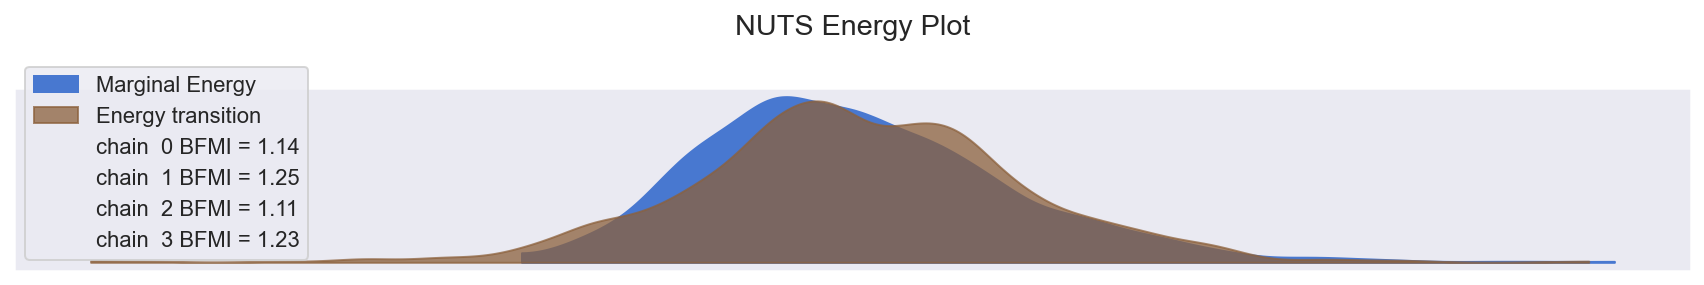

In [37]:
_ = mt.plot_energy(mdl=mdl)

**Observe:**

+ BFMI above 0.3, so [apparently reasonable](https://arxiv.org/pdf/1701.02434.pdf)
+ A little messy though, not symmetric

## 3.3 Evaluate In-Sample PPC

### 3.3.1 Visually Compare In-Sample Predictions to Observations

In [38]:
df_train[['m0', 'm1']].describe().T

count       mean        std       min       25%       50%        75%  \
m0  100.0   1.352141   0.619499  0.390535  0.884585  1.223349   1.673293   
m1  100.0  12.710859  21.483915  0.738527  3.910111  7.389583  13.808335   

           max  
m0    3.437233  
m1  155.694410

In [39]:
eda.display_ht(mt.get_summary(mdl=mdl, rvs=mdl.rvs_ppc))

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
ppc_yhat[2, yhat0]    1.40   0.71    0.36     2.67       0.01     0.01   
ppc_yhat[2, yhat1]   12.75  18.37    0.24    38.11       0.43     0.30   
ppc_yhat[46, yhat0]   1.39   0.71    0.39     2.67       0.02     0.01   
ppc_yhat[49, yhat1]  12.43  16.86    0.20    37.66       0.40     0.28   
ppc_yhat[6, yhat0]    1.36   0.69    0.32     2.57       0.02     0.01   
ppc_yhat[6, yhat1]   13.72  23.64    0.12    39.48       0.54     0.38   

                     ess_bulk  ess_tail  r_hat  
ppc_yhat[2, yhat0]     2073.0    1872.0    1.0  
ppc_yhat[2, yhat1]     2051.0    2058.0    1.0  
ppc_yhat[46, yhat0]    2001.0    1919.0    1.0  
ppc_yhat[49, yhat1]    1919.0    1796.0    1.0  
ppc_yhat[6, yhat0]     1975.0    1895.0    1.0  
ppc_yhat[6, yhat1]     1825.0    1934.0    1.0

'Shape: (200, 9), Memsize 0.0 MB'

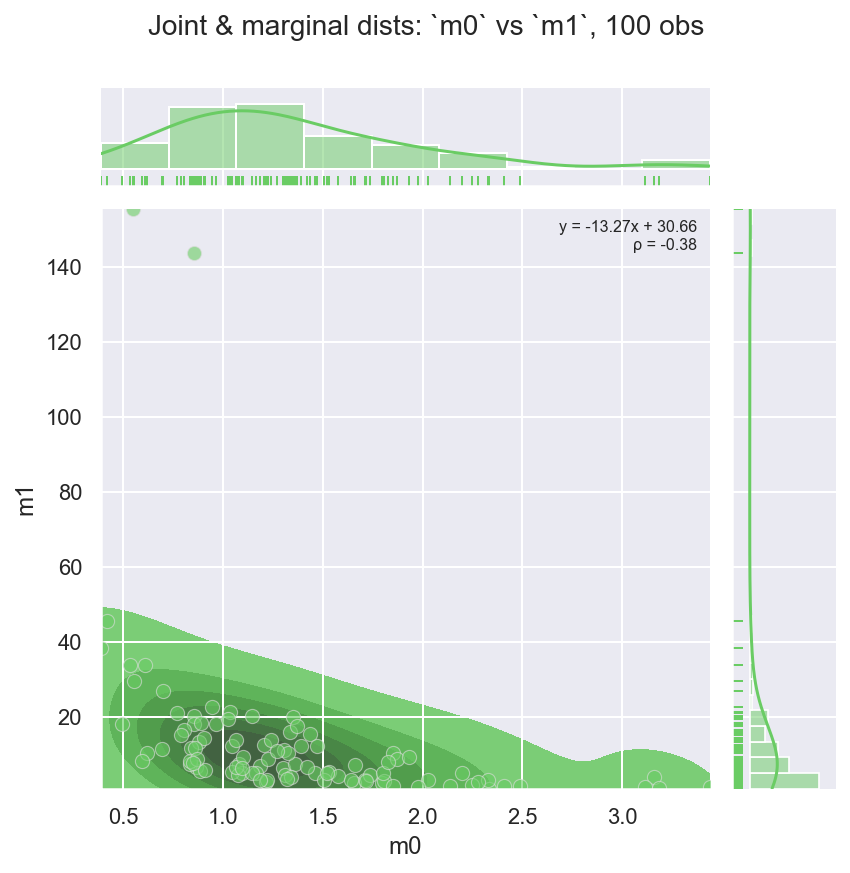

In [40]:
# plot the real observed again
f = eda.plot_joint_numeric(data=df_train, ft0='m0', ft1='m1', kind='kde+scatter', colori=2, 
            subtitle='Observed Marginals with Copula Correlation')

### 3.3.1 View In-Sample PPC Joint `yhat0`, `yhat1`

#### Mean

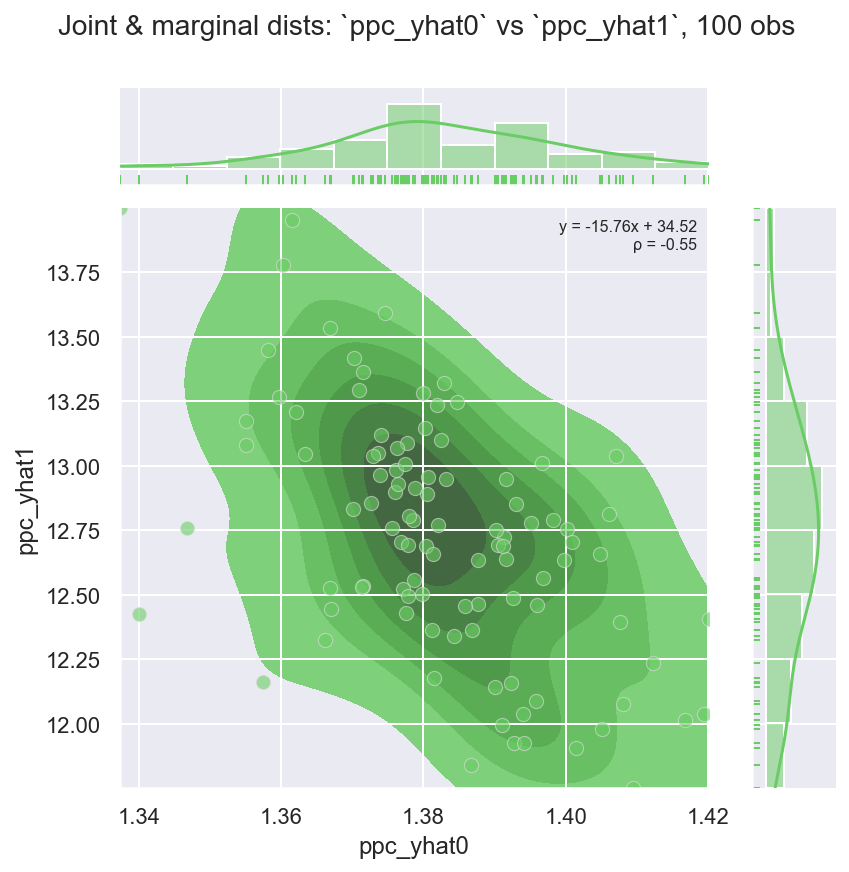

In [41]:
rv = 'ppc_yhat'
cols = mdl.coords[f'{rv}_nm']
x = az.extract(mdl.idata, group='posterior_predictive', var_names=rv).values
dfp_y = pd.DataFrame(np.nanmean(x, axis=2), columns=cols)
f = eda.plot_joint_numeric(data=dfp_y, ft0=cols[0], ft1=cols[1], kind='kde+scatter', 
            colori=2, subtitle='In-Sample Posterior Predictive Marginals (mean)')

**Observe:**

+ Joint distribution contains some of the covariance structure of 
  the actual data
+ These mean values are spread more broadly than for ModelA0

#### Quantiles

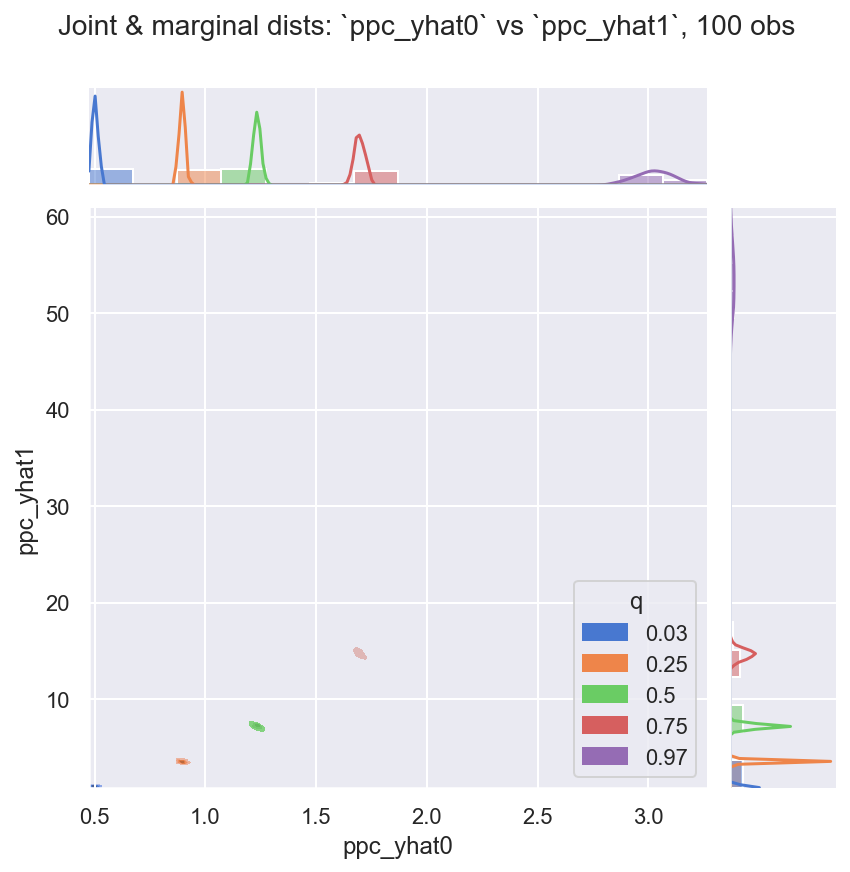

In [42]:
qs = [0.03, 0.25, 0.5, 0.75, 0.97]
dfp_q = pd.DataFrame(np.quantile(x, qs, axis=2).reshape(len(qs)*mdl.n, 2), columns=cols)
dfp_q['q'] = np.repeat([f'{q}'  for q in qs], mdl.n)
f = eda.plot_joint_numeric(data=dfp_q, ft0=cols[0], ft1=cols[1], hue='q', kind='kde',
            legendpos='lower right',
            subtitle='In-Sample Posterior Predictive Marginals (quantiles)')

**Observe**

+ The PPC quantile range covers the range of the observed data quite well
+ The extremes quantiles are still very tightly grouped - variance well managed?

### 3.3.2 Evaluate via ECDF Plot (In-Sample)

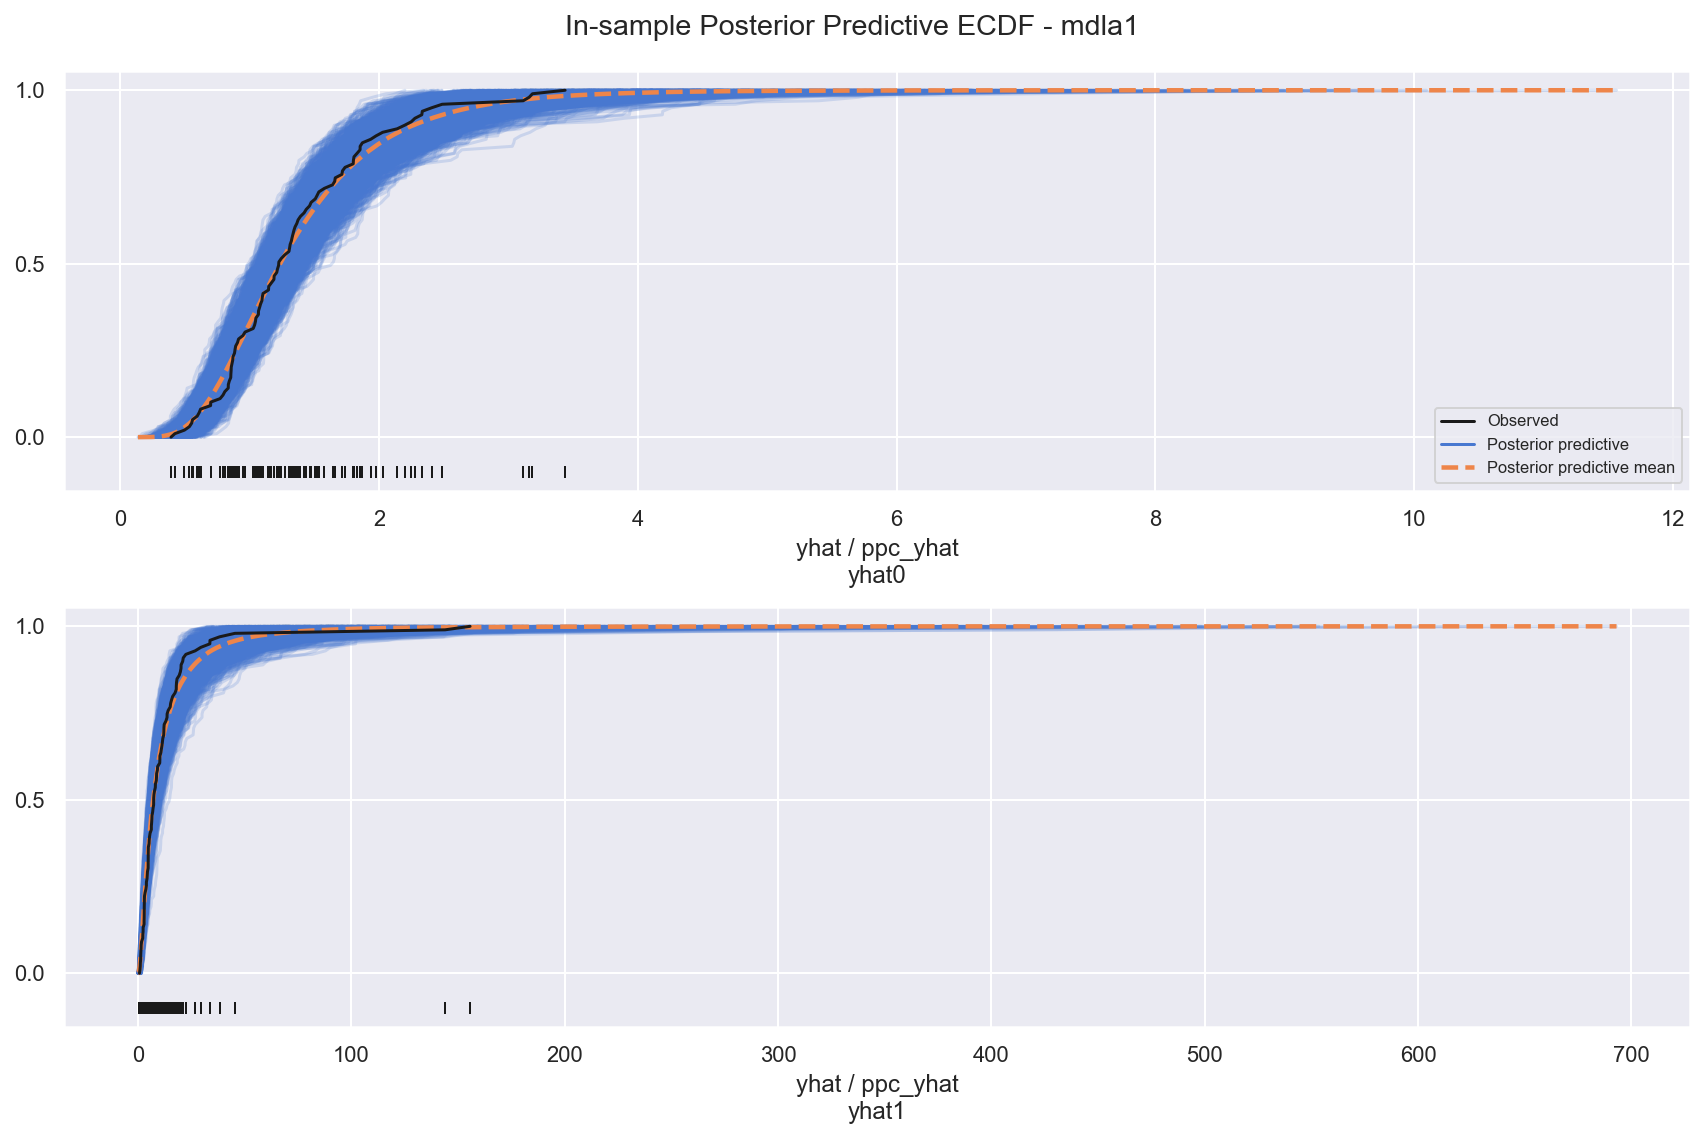

In [43]:
_ = mt.plot_ppc(mdl, group='posterior', data_pairs={'yhat': 'ppc_yhat'}, 
                flatten=['oid'], observed_rug=True)

**Observe:**

+ Bulk: reasonably good fit
+ Tails: reasonable fit but heavier than observed, although `yhat0` is better than ModelA0

### 3.3.3 Evaluate via LOO-PIT Plot (In-Sample)

/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


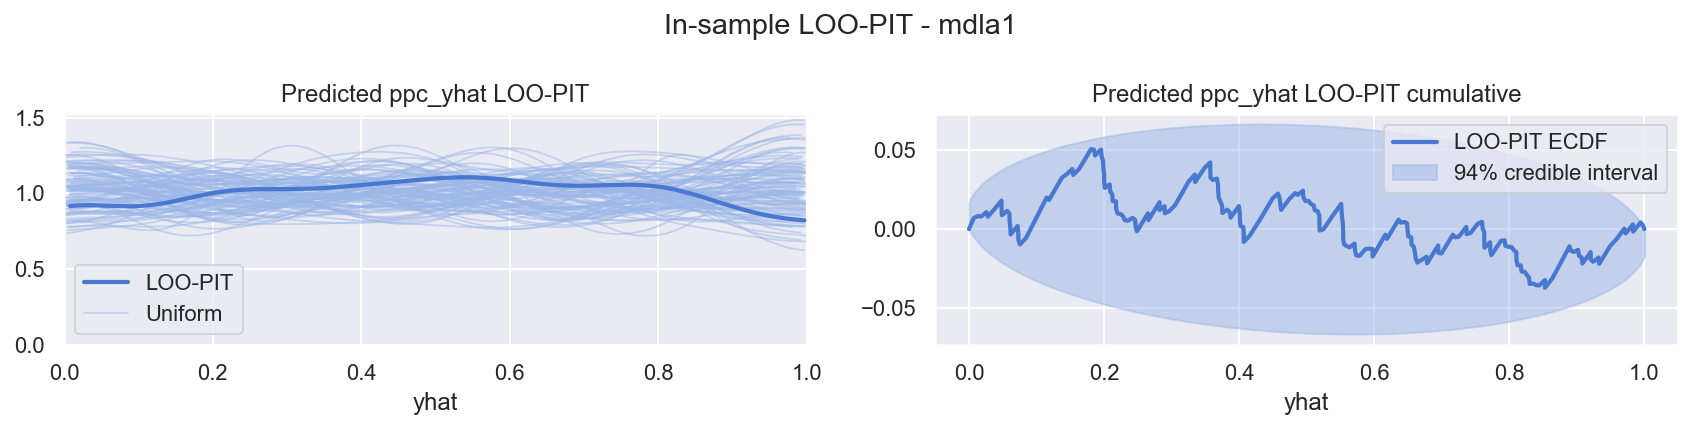

In [44]:
_ = mt.plot_loo_pit(mdl, data_pairs={'yhat':'ppc_yhat'})

**Observe**

+ Very slight overdispersion, but otherwise a good fit
+ Possibly a slightly tighter spread vs ModelA0

### 3.3.4 Compare Log-Likelihood vs other models

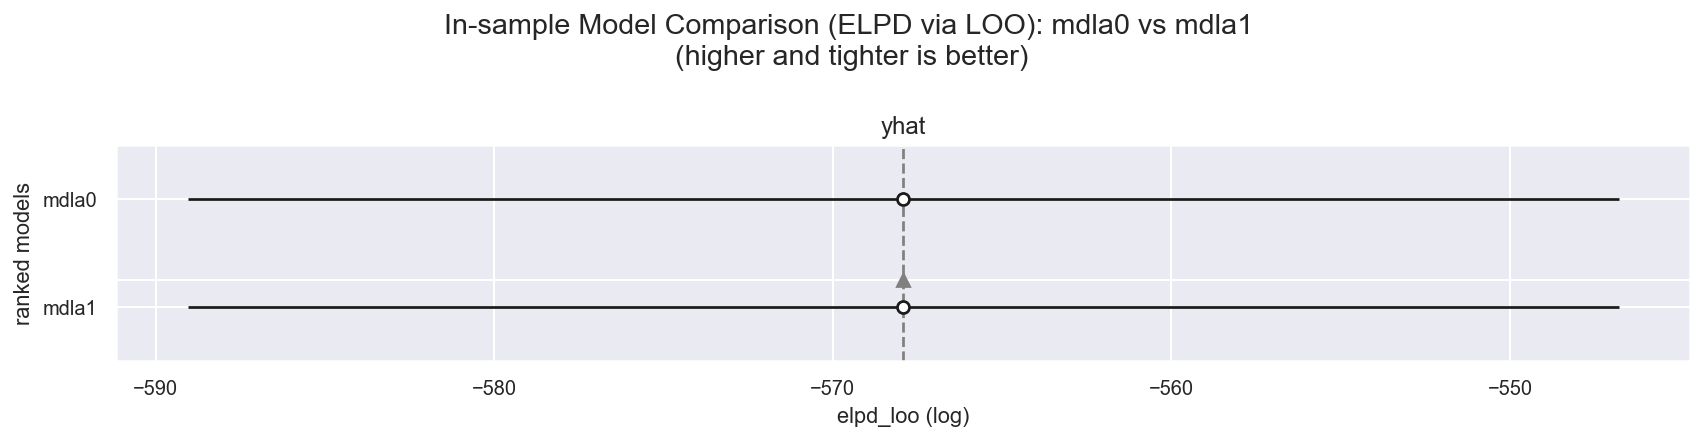

In [51]:
mdla0_idata = trainer.mdlio.read_idata(mdl=mdl)#'idata_mdla0')
idata_dict = {'mdla0': mdla0_idata, 'mdla1': mdl.idata}
f, dfcomps = mt.plot_compare(idata_dict=idata_dict, obs_list=['yhat'])

**Observe:**

+ Curiously, the more basic `mdla0` appears to have better in-sample `elpd_loo`
+ This could be because each marginal is able to fit independently, (potentially overfitting)

---

---

# 4. Evaluate Posterior Parameters

Also in this demo notebook we can evaluate parameter recovery

## 4.1 Hyperpriors on Marginals for Feature Regression

### 4.1.1 Univariate

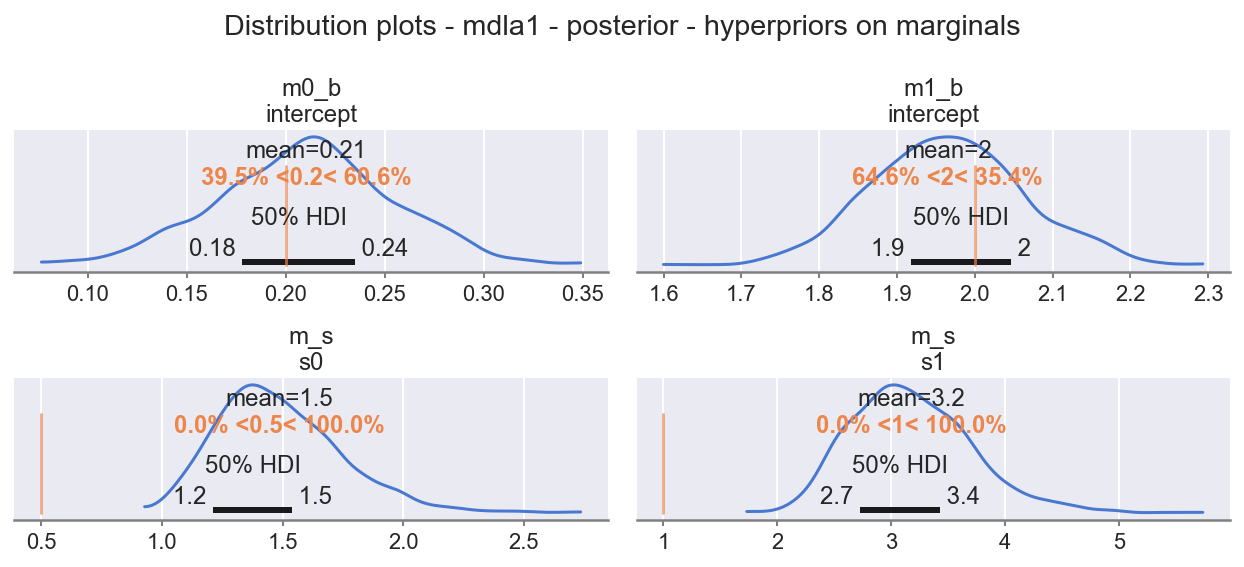

In [52]:
# get ref values from copula builder
refs = [cb.ref_vals['m0_params']['mu'], cb.ref_vals['m1_params']['mu'], 
        cb.ref_vals['m0_params']['sigma'], cb.ref_vals['m1_params']['sigma']
        ]
f = mt.facetplot_krushke(mdl=mdl, txtadd='hyperpriors on marginals',
        rvs=mdl.rvs_marg, ref_vals=refs, m=2, hdi_prob=0.50)

**Observe:**

+ Parameter recovery looks good for `m0_b`, `m1_b`: reference values fall into the 50% HDI of the posterior estimates
+ Parameter recovery is terrible for `s0`, `s1`: clearly the variance is 
  badly affected by introduction of the copula transformations without 
  Jacobian adjustment

### 4.1.2 Bivariate Pairs

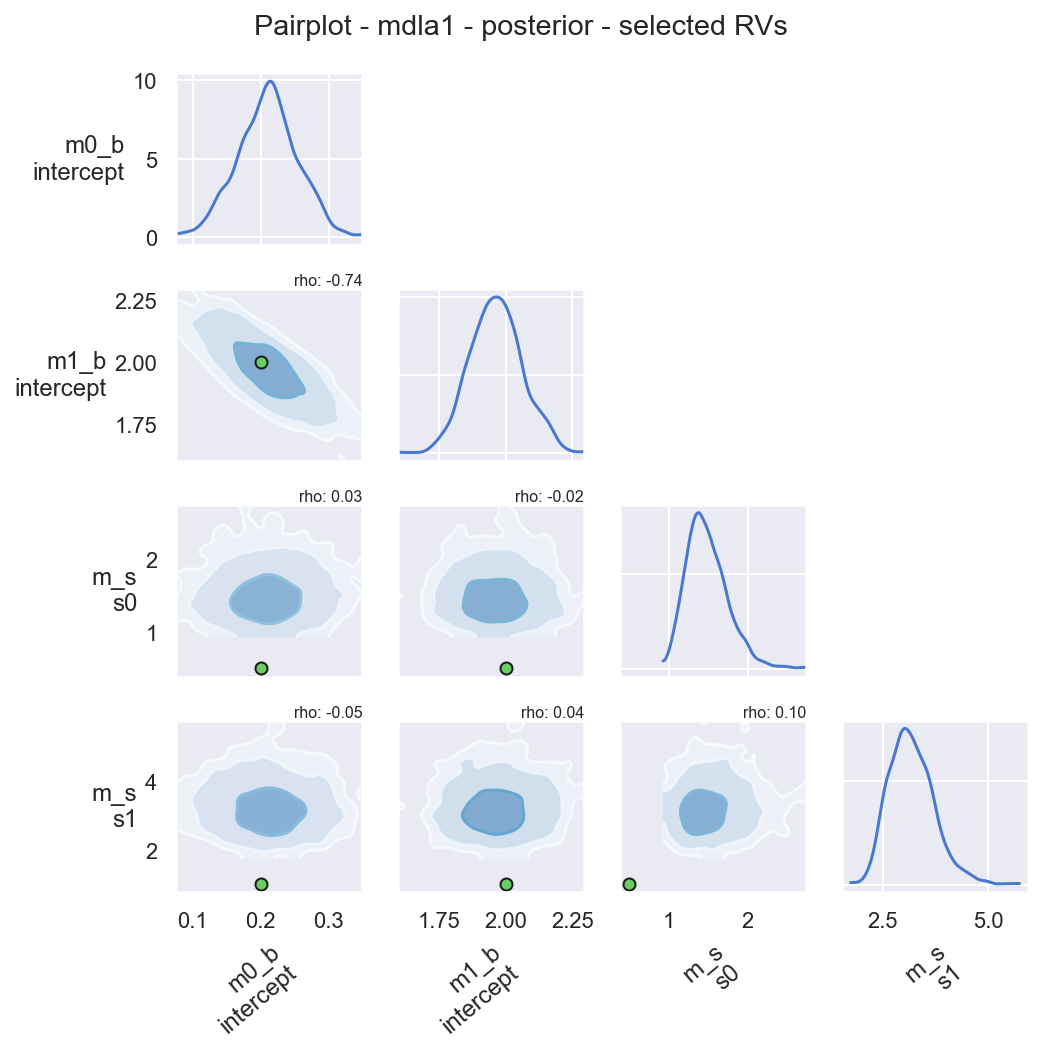

In [53]:
refsd = {
    'm0_b\nintercept': cb.ref_vals['m0_params']['mu'], 
    'm1_b\nintercept': cb.ref_vals['m1_params']['mu'],
    'm_s\ns0': cb.ref_vals['m0_params']['sigma'], 
    'm_s\ns1' :cb.ref_vals['m1_params']['sigma']
    }
f = mt.pairplot_corr(mdl=mdl, rvs=mdl.rvs_marg, ref_vals=refsd)

**Observe:**

+ Another view of the parameter recovery, which seems:
  + good for `m0_b` and `m1_b`
  + but terrible for `m_s`
+ Also view correlation (as expected) between `m0_b` and `m1_b`

## 4.2 Copula Structure

### 4.2.1 LKJCholeskyCov (decomposition and stds)

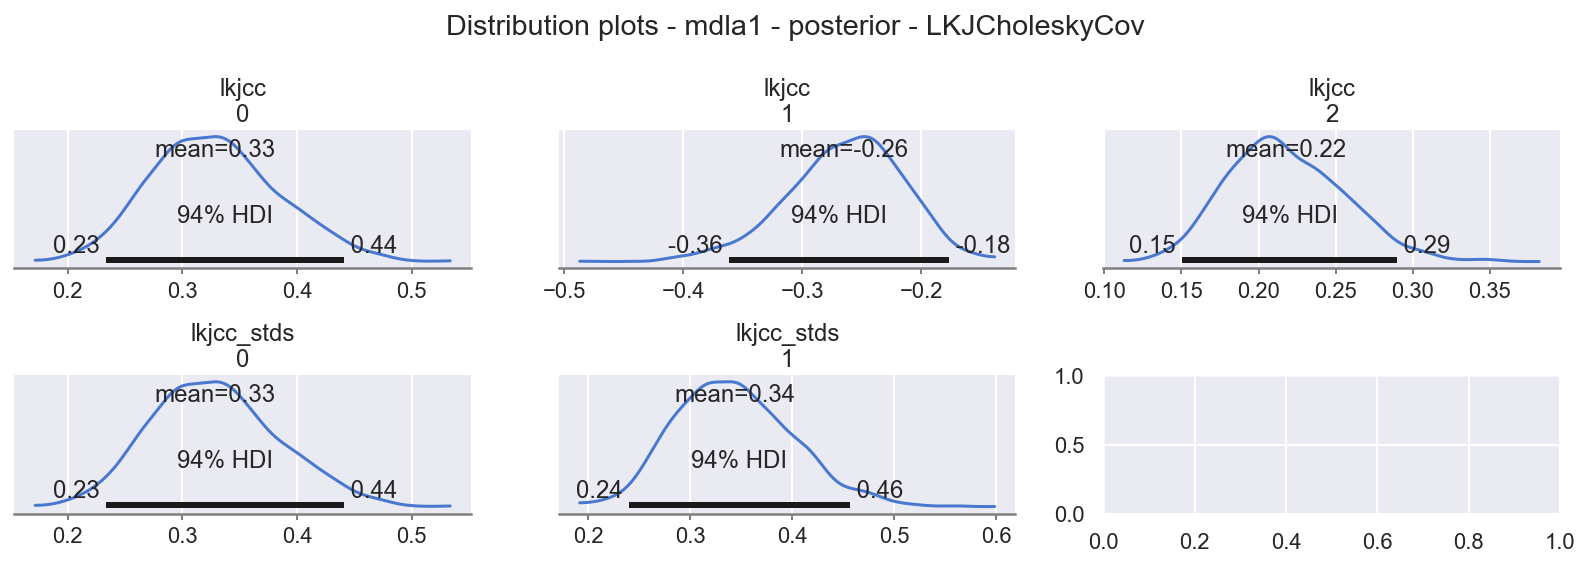

In [54]:
f = mt.facetplot_krushke(mdl=mdl, txtadd='LKJCholeskyCov', rvs=mdl.rvs_lkjcc, m=3)

### 4.2.2 LKJCholeskyCov (Correlation Matrix)

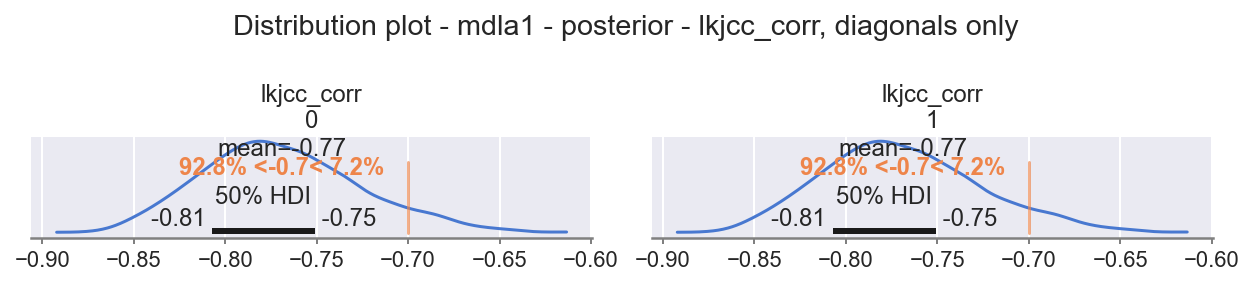

In [55]:
f = mt.plot_lkjcc_corr(mdl=mdl, ref_vals=2*[cb.ref_vals['c_r']], hdi_prob=0.5)

**Observe:**

+ Parameter recovery looks poor: reference values for both `corr` parameters fall outside the 50% HDI of the posterior estimates

### 4.2.3 Check `u0`, `u1` (post-transformation Marginal -> (marginal_dist.CDF) -> Uniform)

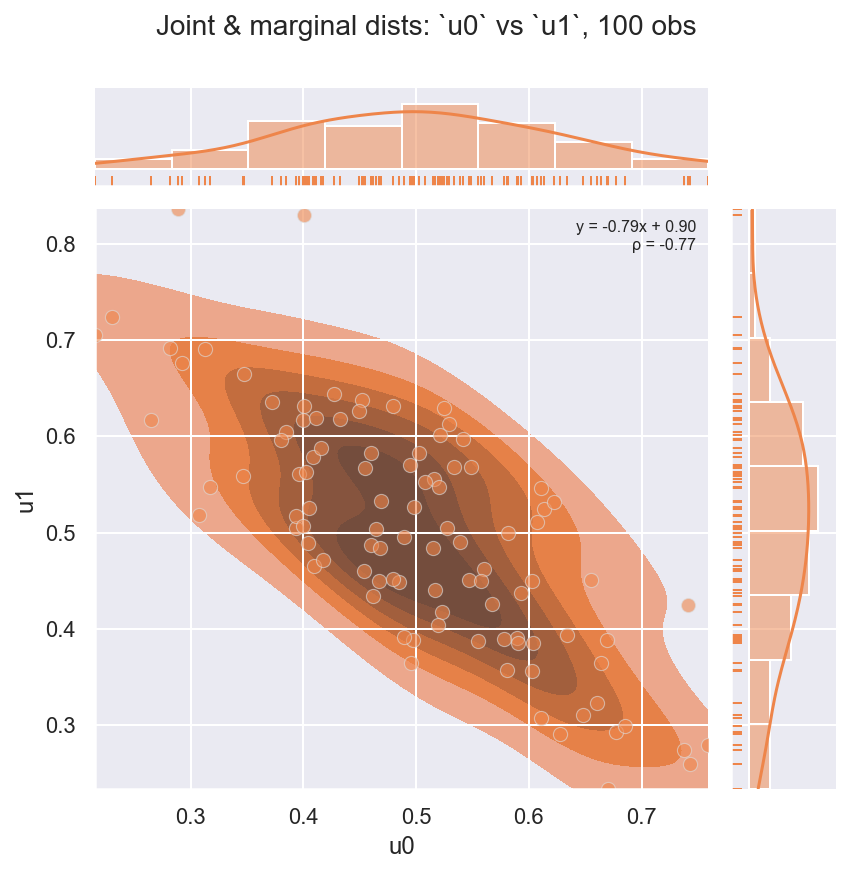

In [56]:
rv = 'u'
cols = mdl.coords[f'{rv}_nm']
x = az.extract(mdl.idata, group='posterior', var_names=rv).values
dfp_y_u = pd.DataFrame(np.nanmean(x, axis=2), columns=cols)
f = eda.plot_joint_numeric(data=dfp_y_u, ft0=cols[0], ft1=cols[1], kind='kde+scatter', 
            colori=1, subtitle='Posterior Predictive Latent Uniform Marginals (mean)')

**Observe:**

+ No erroneous NaNs or limit issues

### 4.2.4 Check `c1`, `c2` (post-transformation Uniform -> (normal.invCDF) -> MvN)

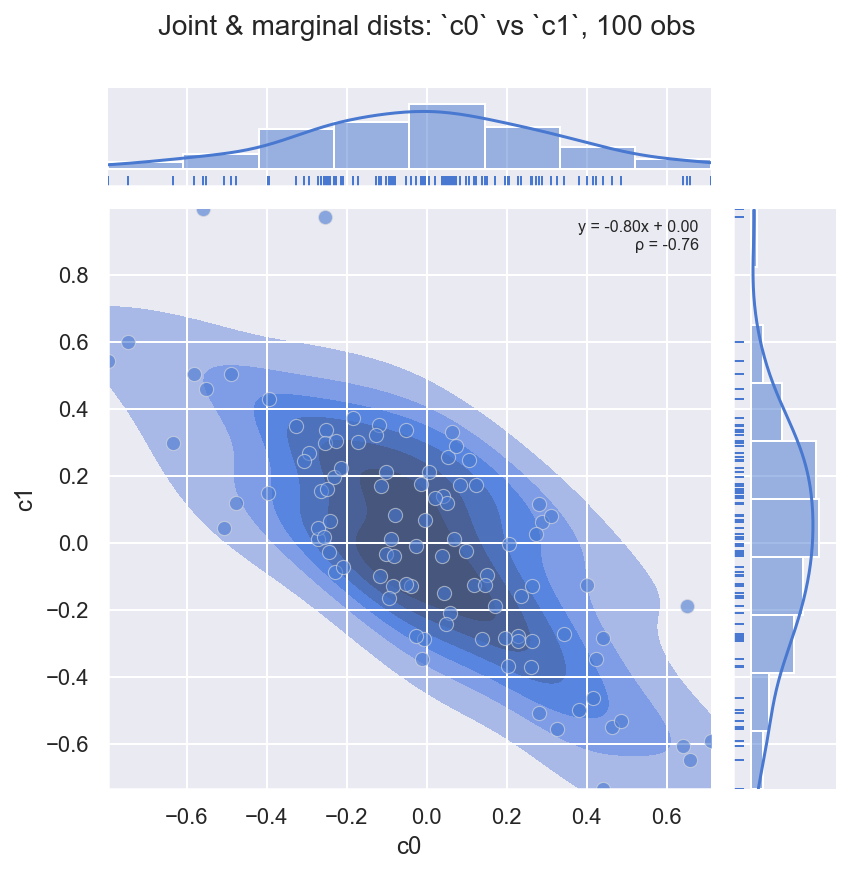

In [57]:
rv = 'c'
cols = mdl.coords[f'{rv}_nm']
x = az.extract(mdl.idata, group='posterior', var_names=rv).values
dfp_y_u = pd.DataFrame(np.nanmean(x, axis=2), columns=cols)
f = eda.plot_joint_numeric(data=dfp_y_u, ft0=cols[0], ft1=cols[1], kind='kde+scatter', 
            subtitle='Posterior Predictive Latent Copula (mean)')

**Observe:**

+ Covariance looks reasonable and nearly centered on zero as per 
  the reference values
+ Correlation $\rho \approx 0.7$ not too far from reference value
+ Marginals are much tighter than the actual data though

#### 4.2.4.2 Percentiles across samples

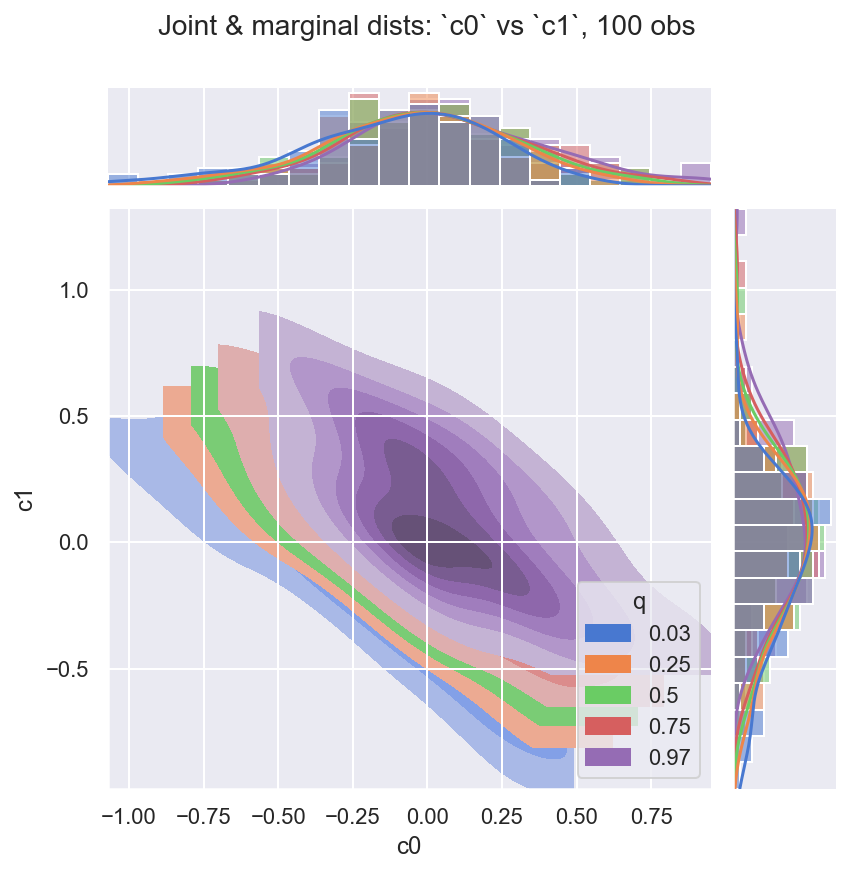

In [58]:
qs = [0.03, 0.25, 0.5, 0.75, 0.97]
dfp_c_q = pd.DataFrame(np.quantile(x, qs, axis=2).reshape(len(qs)*mdl.n, 2), columns=cols)
dfp_c_q['q'] = np.repeat([f'{q}'  for q in qs], mdl.n)
f = eda.plot_joint_numeric(data=dfp_c_q, ft0=cols[0], ft1=cols[1], hue='q', kind='kde',
            legendpos='lower right',
            subtitle='Posterior Predictive Latent Copula (by quantile)')

**Observe:**

+ All very similar spreads across the quantiles

---

---

# 5. Predict Out-of-Sample (Holdout Set)

## 5.1 Sample PPC holdout

In [59]:
# replace obs with dfx_pholdout and build
mdl.replace_obs({'obs_m0': dfx_m0_holdout, 'obs_m1':dfx_m1_holdout})
mdl.build()

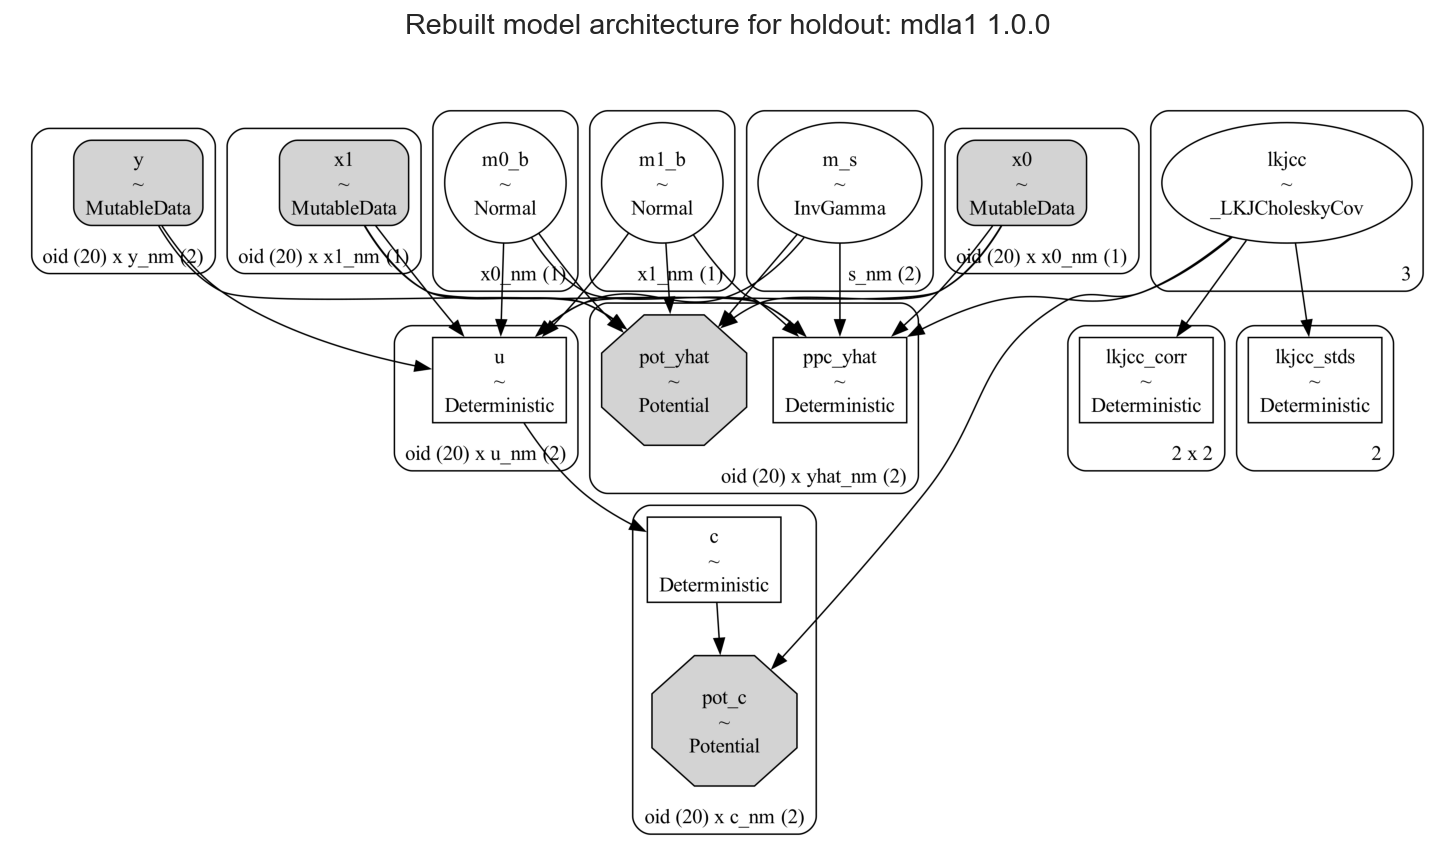

In [60]:
fqn = trainer.mdlio.write_graph(mdl, txtadd='holdout')  # output model graph to prove rebuilt
f = eda.display_image_file(fqn, 
    title=f'Rebuilt model architecture for holdout: {mdl.name} {mdl.version}', figsize=(12, 6))

In [61]:
idata_holdout = mdl.sample_posterior_predictive(store_ppc=False, 
        ppc_insample=True,  # hack to ensure output is named posterior_predictive so we can do EDCF
        var_names=mdl.rvs_ppc)

GROUP = 'posterior_predictive'  # predictions

idata_holdout

/Users/jon/workspace/oreum/oreum_core/oreum_core/model_pymc/base.py:230: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(**{**kws, **kwargs})
/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(


Inference data with groups:
	> posterior_predictive
	> constant_data

## 5.2 Plot Holdout

Calling back to **1.2.6 Compare the Impact on Joint Distribution** we might consider the PPC Joint Distribution here too. We will keep with the theme that this might represent a Expected Loss Cost $E_{loss}$

NOTE:

+ Within each marginal, the samples for the posterior parameters of a submodel 
  are coherent across the joint posterior parameter space
+ This means for example, that within parameters `yhat0` etc, each of 
  samples `0, 1, 2, 3 ... j` gives us the full state of the model at that point 
  in the Markov chain
+ So, we use all parameter values at each sample `0, 1, 2, 3 ... j`, to get 
  `j` estimates of the posterior parameter values, and thus the predictions
+ We usually set `j = 2000`, so we have $2000$ predictions for each observation

In [62]:
yhat = az.extract(idata_holdout, group=GROUP, var_names=mdl.rvs_ppc).values
yhat_eloss = np.product(yhat, axis=1)
yhat_eloss.shape

(20, 2000)

### 5.2.1 Plot Holdout Full Set Distribution

In [63]:
df_yhat_eloss = pd.DataFrame(yhat_eloss, index=dfx_m0_holdout.index)
dfm_yhat_eloss = df_yhat_eloss.reset_index().melt(
                        id_vars='index', value_name='yhat', var_name='sample')
eda.display_ht(df_yhat_eloss)

0      1      2      3      4      5      6      7      8      9     \
108  14.88  18.32  13.14  23.44  20.57   9.57  22.22   4.00   4.97  19.93   
11    4.66   6.55   2.74  16.85   9.40   5.46   9.38  13.61   7.73   7.59   
103  21.44   4.26   6.54  20.13   9.31   4.77  14.46   9.20   3.97  17.44   
65    9.52   5.19   4.27  10.24  14.37  20.05  18.67  21.40  32.37  17.18   
77   26.26   4.37  15.25   6.67  23.80   9.29  22.06   5.27  15.57   9.23   
8    15.27  10.12   7.20  38.72  27.00  16.06  14.79   6.64  34.49   9.52   

      10     11     12     13     14     15     16     17     18     19    \
108  20.79   4.32   4.09   6.34  28.71  13.67  18.28   8.47   5.28  13.86   
11   15.95   7.86   6.26  12.57   2.74   5.80  14.81  17.27   6.35  11.17   
103   6.23   9.98   7.45   9.52   4.83   8.10   2.96   3.21   5.07   4.38   
65    3.81   5.72   6.23  26.65   1.97   5.58   6.51   7.41   3.27   9.10   
77   19.23  16.28  15.02   3.21  20.15   3.86   3.81   9.19   7.39   8.00   
8     3.09   6.31   6.45   2.76  15.47   9.22   9.94   1.13  23.56   8.94   

      20     21     22     23     24     25     26     27     28     29    \
108   7.20   5.33  17.20  25.62   1.22  20.52   9.78  10.45  17.19  13.33   
11   25.29   1.27  11.31   6.43  22.46   3.25   3.93  16.01  13.22   7.21   
103   5.16   4.93  44.56   6.38  15.03   5.67  11.21   9.62  11.13   5.78   
65    6.18  10.78   4.20  10.67  18.11  19.56  10.11   5.71  38.56   9.51   
77    5.85   2.45  11.44   8.58   2.92  17.57   4.70  13.98   7.12  21.67   
8     4.66   2.18  12.69  21.90   5.59   3.04  10.60  16.48   1.42   7.39   

      30     31     32     33     34     35     36     37     38     39    \
108  20.08  11.18  14.43   7.46  19.41  14.44   6.86   8.61  14.81  11.23   
11   14.45  11.93   7.07   6.17   3.27   8.84  15.44   4.68   5.20   5.24   
103  21.90   5.08   4.53  15.49  13.03  22.49  16.04  28.70   6.51   7.49   
65   13.16   7.45  15.03  10.99   8.15   6.00   4.91   1.22   5.68  24.37   
77    3.95   8.77   7.26  12.69  21.19   4.18   9.72  17.25   4.51  21.49   
8     3.69  22.74  36.92   3.16   7.12   3.03  13.23   8.16   8.15   4.78   

      40     41     42     43     44     45     46     47     48     49    \
108  13.39  10.07  39.91   3.14   5.37   9.22   7.41   9.20  18.76   3.10   
11   10.07   7.04  10.70   2.15   6.10  12.15  10.04  20.24  12.70   4.99   
103   3.69  11.54   1.31   9.30   8.91  14.60   5.76  21.67   5.81  61.56   
65   12.88  45.24  18.90   7.05  14.78   3.97   3.50  15.57  21.86  33.90   
77   12.31  11.10  24.76  20.83   9.91  19.78  10.75  10.11  10.62   7.39   
8     3.44  27.06  11.53   9.33  13.01  17.30   4.32   3.85   5.51  20.87   

      50     51     52     53     54     55     56     57     58     59    \
108  15.77  14.86   2.83  34.14   7.23   1.85   6.53   2.51  12.19   7.88   
11    5.73  22.19   5.17   7.43   7.69   6.26   4.79   7.20   8.38   3.89   
103   5.97  13.00   8.69  46.25   2.42   3.64  13.07   2.13   4.64  25.75   
65   10.73   8.39   1.52  12.21   8.29  20.39   9.17   4.94   6.81   4.02   
77    6.08  18.03   6.19   9.96  11.49   3.78   8.07  36.30  25.13  14.61   
8     4.02  12.89  14.06   7.79   7.28   6.63  20.15  11.52   8.08  12.64   

      60     61     62     63    64     65     66     67     68     69    \
108  29.47  16.64   3.16  10.97  5.10   9.77   6.62   9.98   9.60  28.09   
11   13.08  35.84   4.58  19.71  5.08  11.93  15.28  29.76  24.73  17.78   
103  15.07   6.67  42.46  12.35  7.22  15.01  34.90  15.72  36.76   2.77   
65    5.33   2.32   3.82   8.78  0.66  38.18  11.78  16.30   7.47   3.81   
77    6.96  13.47   3.85   9.67  6.45   2.77  50.85   5.96   4.18   5.63   
8     4.89   3.78  10.63   5.79  5.32   2.89  24.06  13.46  38.33   4.77   

      70     71     72     73     74     75     76     77     78     79    \
108   6.13  10.68  13.67   5.02   3.98  11.69  14.34  30.57   6.32  12.80   
11   19.72   5.74  11.74   8.04   2.38  19.26  12.72   8.43  13.98   5.31   
10

'Shape: (20, 2000), Memsize 0.3 MB'

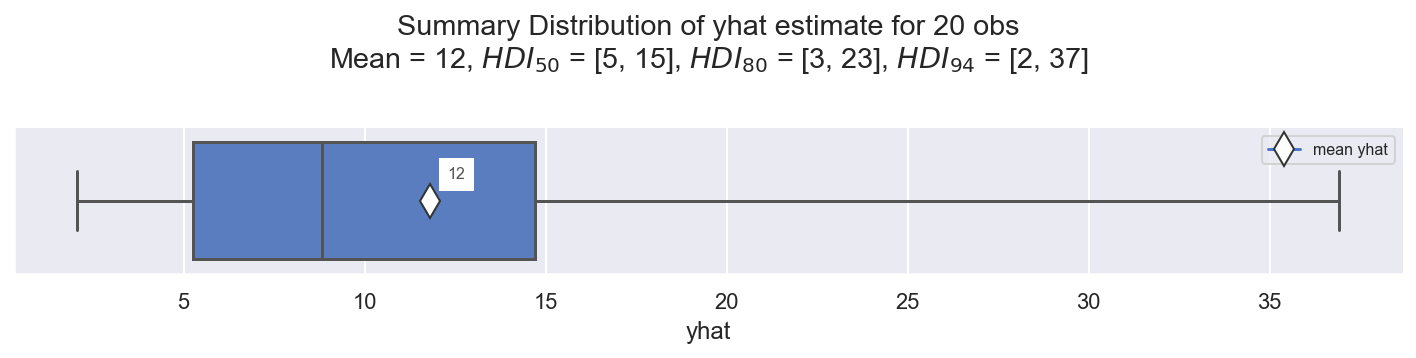

In [64]:
f = eda.plot_estimate(dfm_yhat_eloss, len(df_yhat_eloss), yhat='yhat')

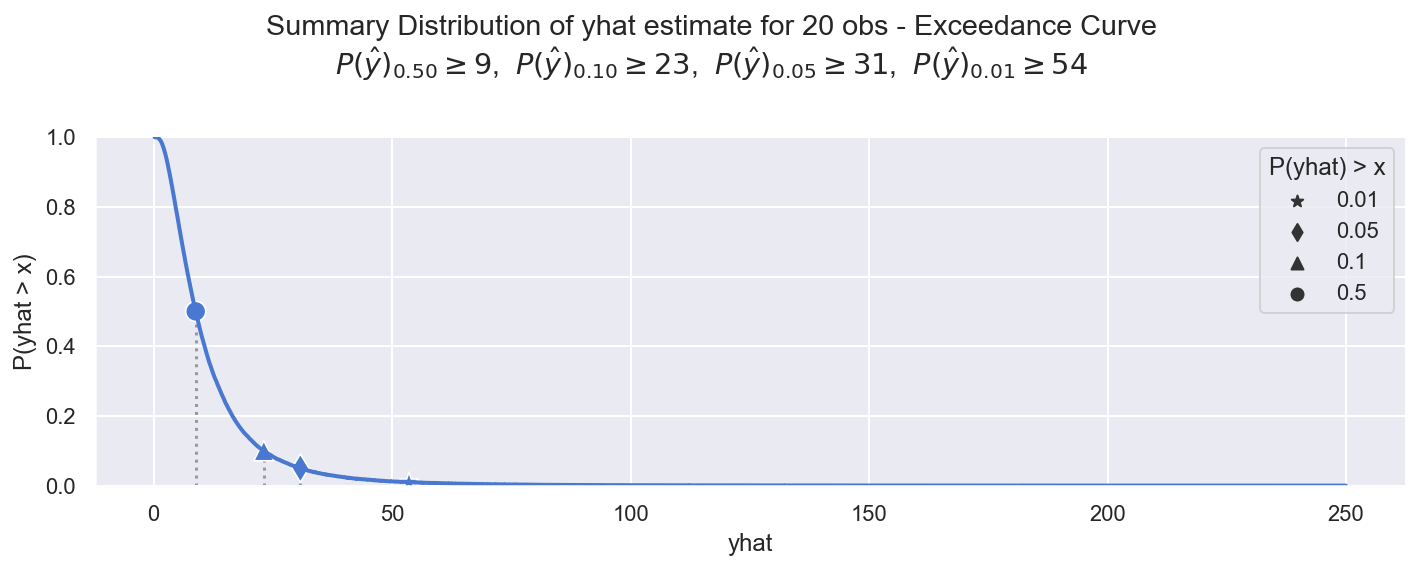

In [65]:
f = eda.plot_estimate(dfm_yhat_eloss, len(df_yhat_eloss), yhat='yhat', kind='exceedance')

**Observe:**

+ Substantially tighter (shallower tail) holdouts than ModelA0 - much less variance
+ Much lower mean

### 5.2.2 Plot holdout Individual Observations

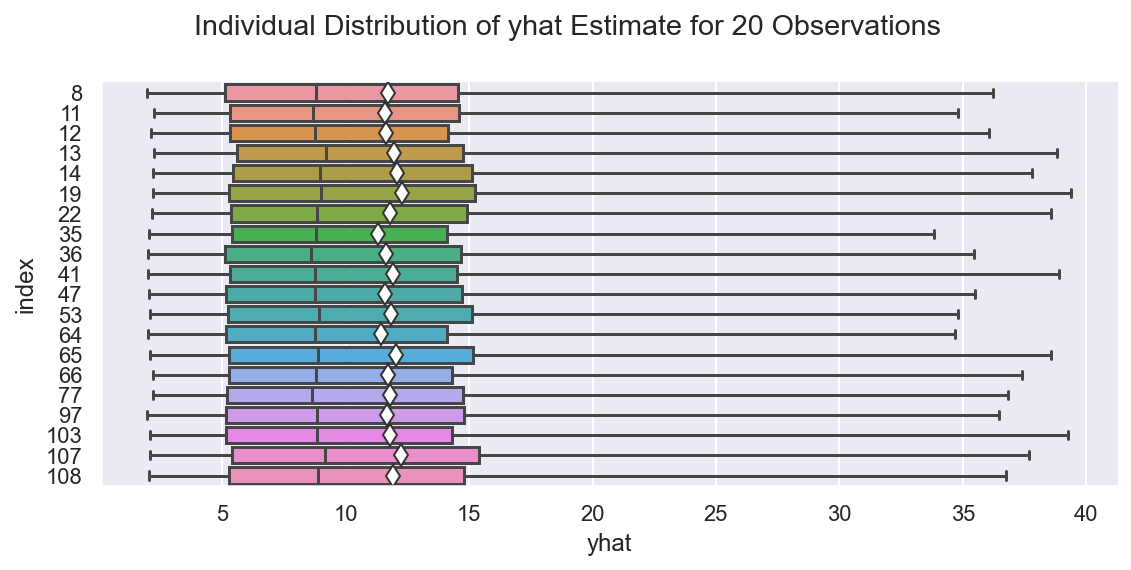

In [66]:
mn_pt_kws=dict(markerfacecolor='w', markeredgecolor='#333333', marker='d', markersize=8)
box_kws=dict(kind='box', sym='', orient='h', showmeans=True, whis=(3, 97), meanprops=mn_pt_kws)
nobs = len(df_yhat_eloss)
gd = sns.catplot(x='yhat', y='index', data=dfm_yhat_eloss, **box_kws, height=4, aspect=2)
_ = gd.fig.suptitle(f'Individual Distribution of yhat Estimate for {nobs} Observations')
_ = gd.fig.tight_layout()

### 5.2.3 Mean Joint Distribution

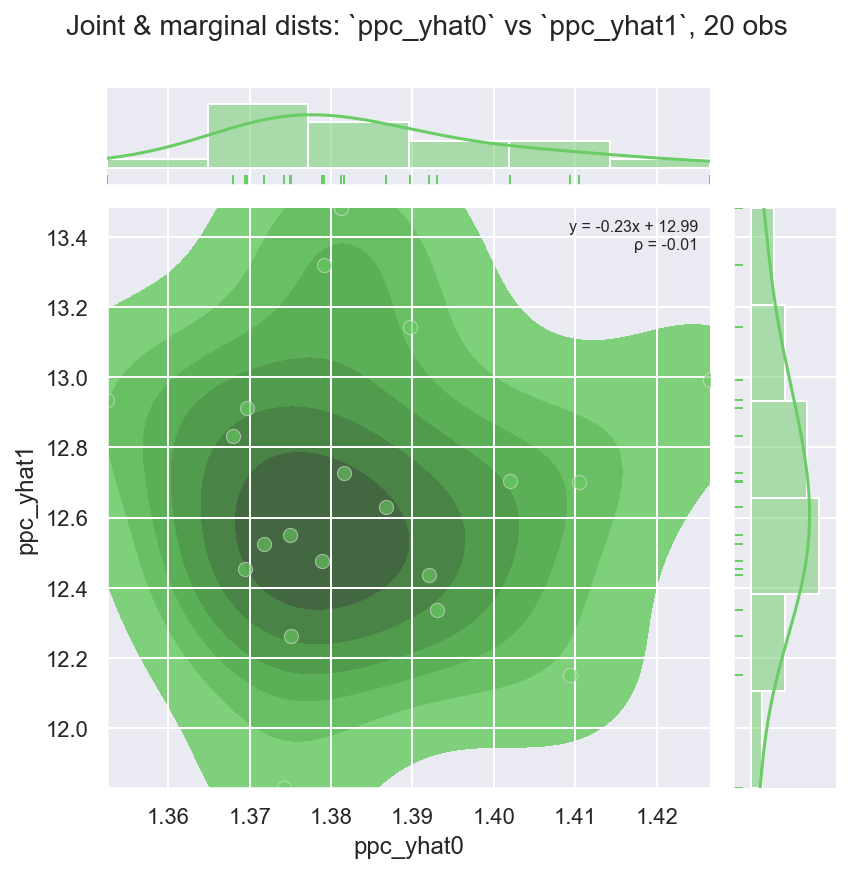

In [67]:
rv = 'ppc_yhat'
cols = mdl.coords[f'{rv}_nm']
x = az.extract(idata_holdout, group=GROUP, var_names=rv).values
dfp_y = pd.DataFrame(np.nanmean(x, axis=2), columns=cols)
f = eda.plot_joint_numeric(data=dfp_y, ft0=cols[0], ft1=cols[1], kind='kde+scatter', colori=2, 
            subtitle='holdout Out-of-Sample Posterior Predictive Marginals (mean)')

**Observe:**

+ Looks reasonable
+ Marginals and joint look close to holdout actual values

### 5.2.4 Quantile Joint Distribution

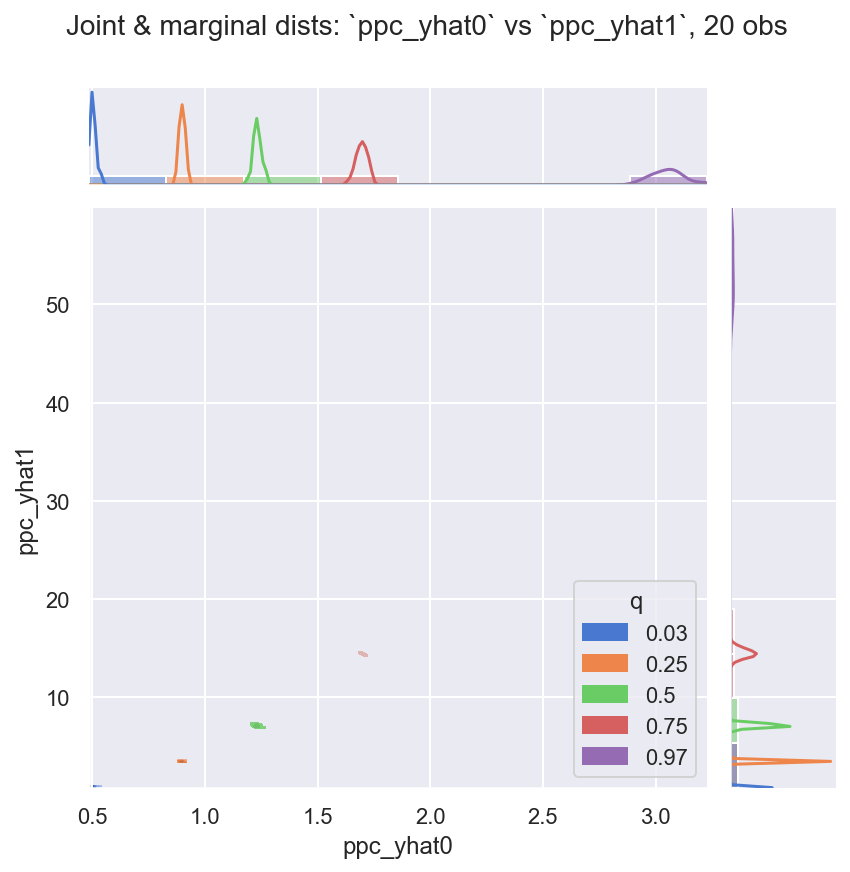

In [68]:
qs = [0.03, 0.25, 0.5, 0.75, 0.97]
dfp_q = pd.DataFrame(np.quantile(x, qs, axis=2).reshape(len(qs)*mdl.n, 2), columns=cols)
dfp_q['q'] = np.repeat([f'{q}'  for q in qs], mdl.n)
f = eda.plot_joint_numeric(data=dfp_q, ft0=cols[0], ft1=cols[1], hue='q', kind='kde',
            legendpos='lower right',
            subtitle='holdout Out-of-Sample Posterior Predictive Marginals (quantiles)')

**Observe**

+ Very interesting! The PPC quantile range looks reasonable

In the real world, we have to stop here, because in a **holdout** dataset / scenario we dont have `y`

---

# 6. Evaluate Predictions (Holdout Set)

**IMPORTANT NOTE** 

Strictly speaking, in a **holdout** dataset / scenario we dont have `y`, but in
this worked example Notebook we do have `y`, so we can treat this more like a 
**Holdout** dataset / scenario, and add several evaluations including:

+ Plot Summarised Predictions with overplotted Actual
+ Plot PPC ECDF
+ Plot Coverage / Calibration
+ Plot RMSE and R^2


## 6.1 Evaluate holdout Joint Distribution ($E_{loss}$)

### 6.1.1 Plot Summarised Predictions with overplotted Actual

In [69]:
y_m0 = dfx_m0_holdout['m0'].values
y_m1 = dfx_m1_holdout['m1'].values
y_eloss = y_m0 * y_m1
df_y_eloss = pd.DataFrame({'y': y_eloss}, index=dfx_m0_holdout.index).reset_index()

PosixPath('/Users/jon/workspace/oreum/oreum_copula/plots/101_6_1_1_holdout_prediction_mdla1.png')

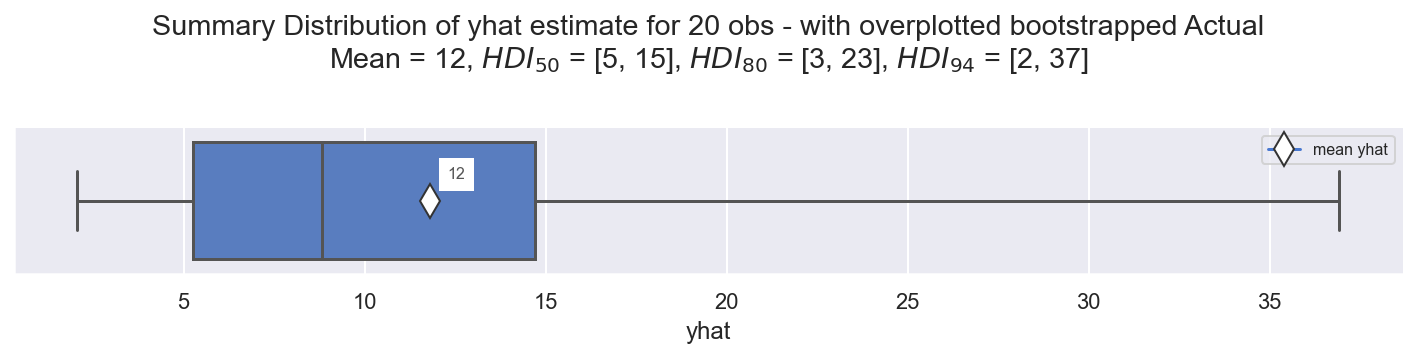

In [70]:
f = eda.plot_estimate(dfm_yhat_eloss, len(df_yhat_eloss), yhat='yhat', 
                    arroverplot=df_y_eloss['y'], txtadd='with overplotted bootstrapped Actual')
figio.write(f, fn=f'101_6.1.1_holdout_prediction_{mdl.name}')

**Observe:**

+ Now we can see the prediction from this improved copula model is much better than ModelA0, variance is smaller and the mean is much closer
+ The overplotted actual sample mean is 9.3, and the estimated mean is 11.8,
  a $11.8/9.3 \sim +27\%$ overestimate
+ This is a $74-27 = 47\%$ absolute improvement on the overestimate by ModelA0


### 6.1.2 Plot PPC EDCF

In [71]:
# hacky correct for sample_posterior_predictive not creating observed data 
# (because model observed_RVs is empty)
if 'observed_data' not in idata_holdout.groups():
    idata_holdout.add_groups(observed_data=deepcopy(mdl.idata.observed_data))

idata_holdout

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

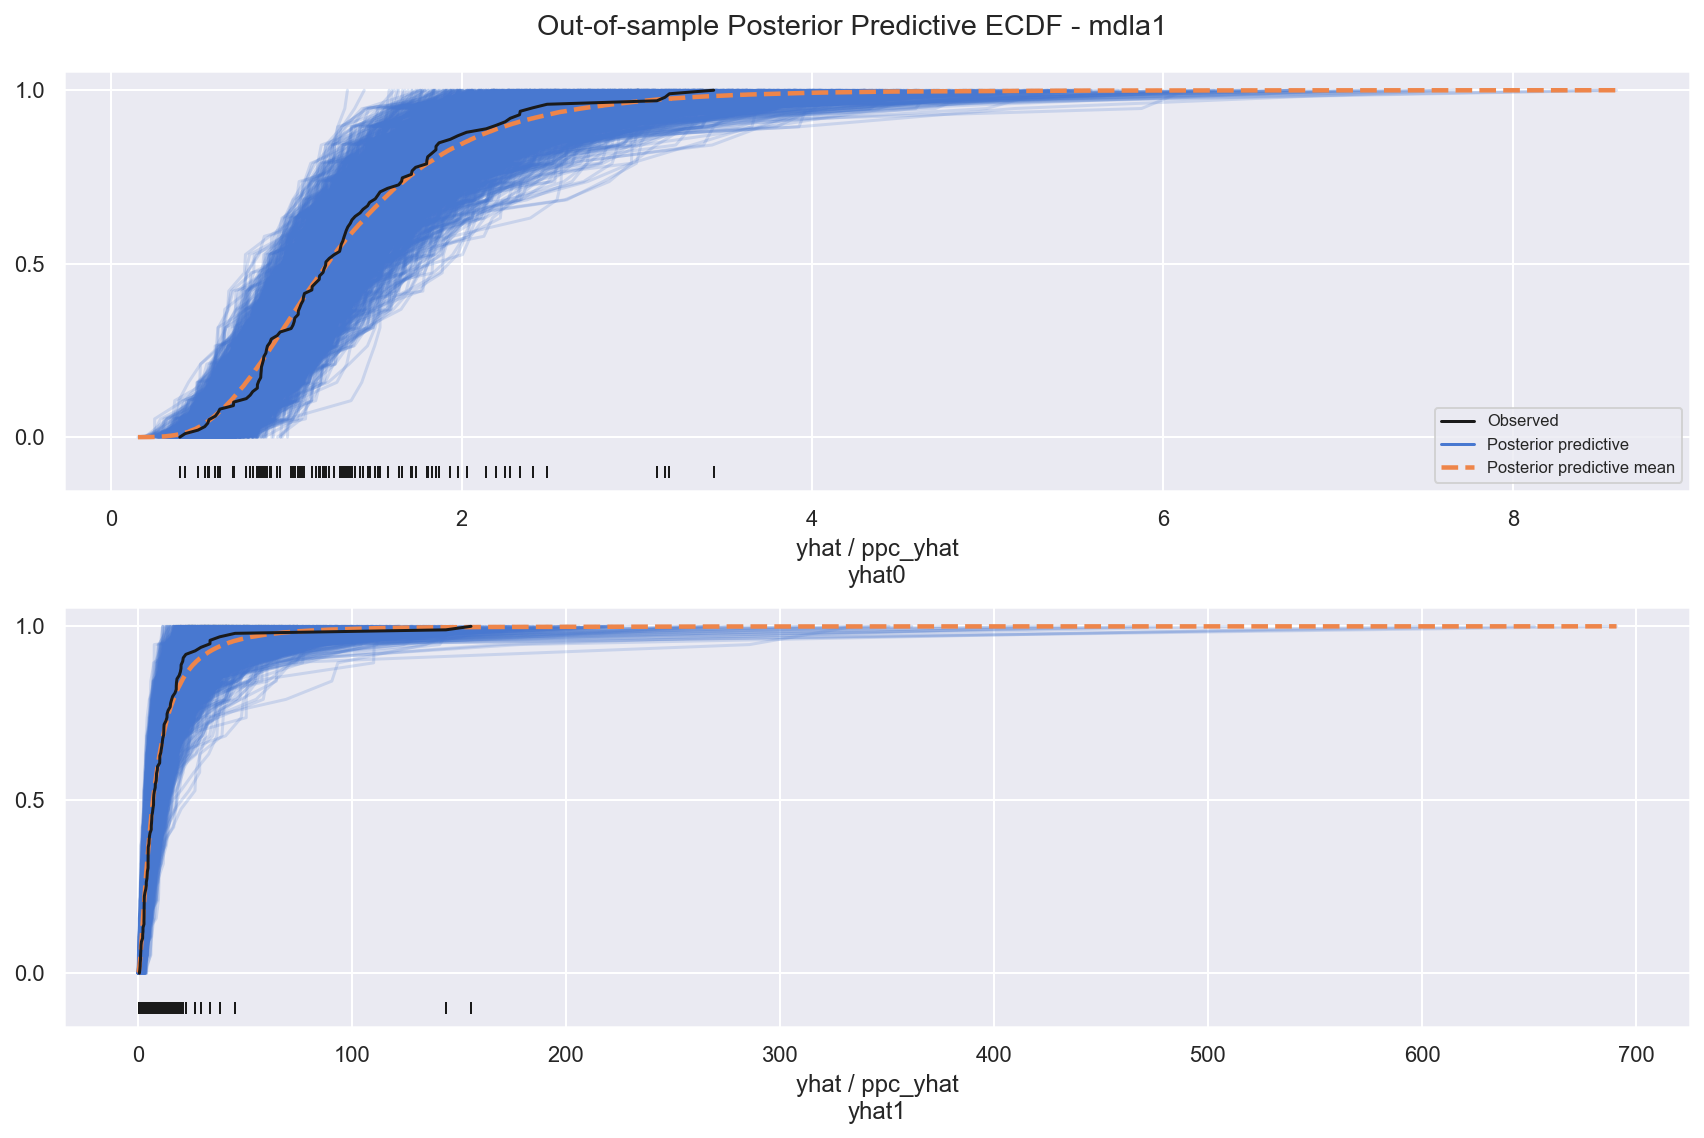

In [72]:
_ = mt.plot_ppc(mdl, idata=idata_holdout, group='posterior', insamp=False,
                data_pairs={'yhat': 'ppc_yhat'}, flatten=['oid'], observed_rug=True)

**Observe:**

+ Bulk: pretty good fits
+ Tails: good fit, a little heavier than observed - much better (tighter) tails than ModelA0, suggesting Model A0 overfitted

### 6.1.3 Plot Coverage

In [73]:
y_m0 = dfx_m0_holdout['m0'].values
y_m1 = dfx_m1_holdout['m1'].values
y_eloss = y_m0 * y_m1

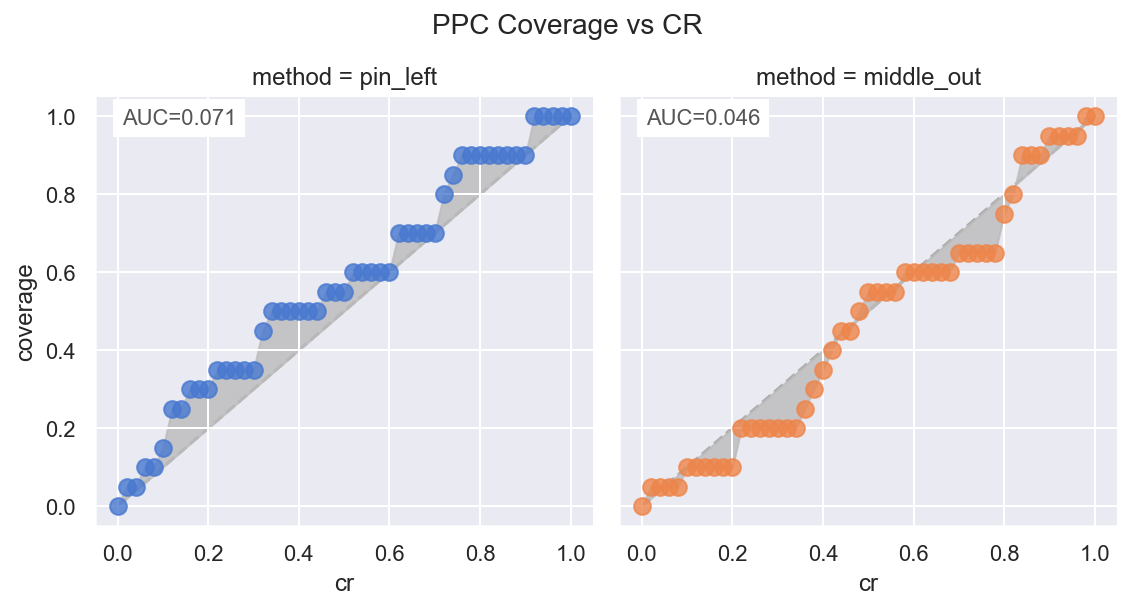

In [74]:
df_cov_eloss = mt.calc_ppc_coverage(y_eloss, yhat_eloss.T)
f = eda.plot_coverage(df_cov_eloss)

**Observe:**

+ Looks well-calibrated
+ AUC: much smaller than ModelA0 on middle out - much better balanced

### 6.1.4: Plot RMSE and R^2

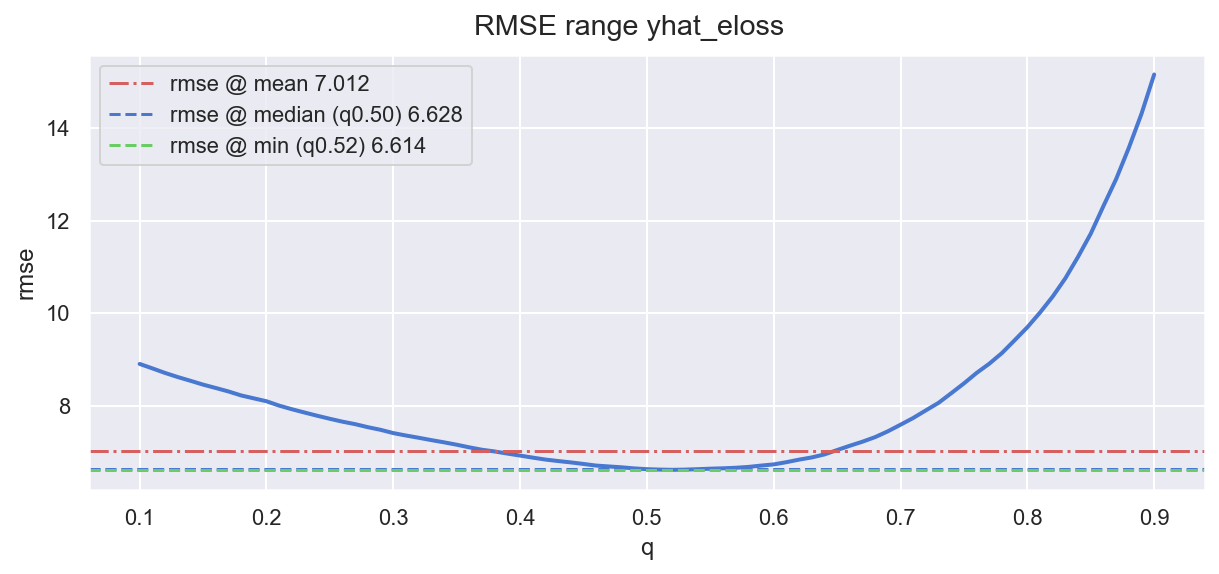

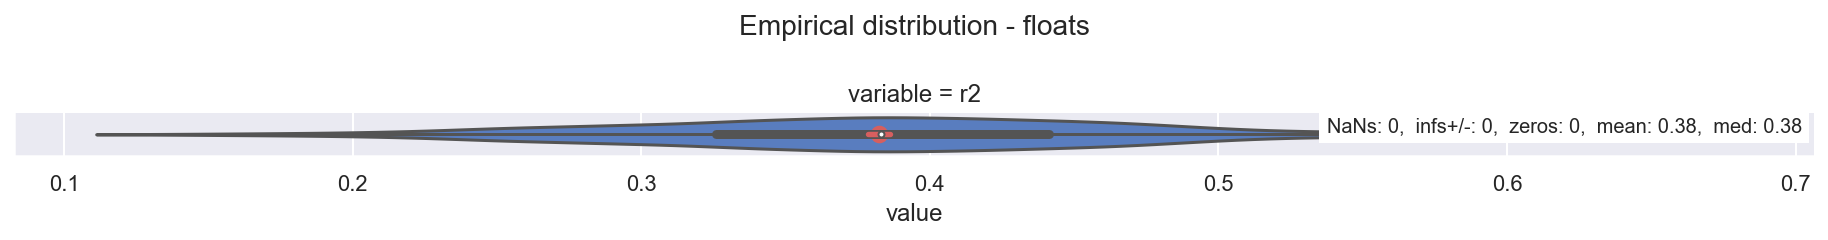

In [75]:
rmse, rmse_pct = mt.calc_rmse(y_eloss, yhat_eloss.T)
f = eda.plot_rmse_range(rmse, rmse_pct, yhat_name='yhat_eloss')

r2 = mt.calc_bayesian_r2(y_eloss, yhat_eloss)
f = eda.plot_float_dist(r2, ['r2'], log=False)

**Observe:**

+ RMSE lower variance than ModelA0, and the mean is much lower 
+ R^2 mean very slightly lower than ModelA0

## 6.2 Evaluate Marginal Distributions

**IMPORTANT NOTE** 

Strictly speaking, in a **holdout** dataset / scenario we dont have `y`, but in
this worked example Notebook we do have `y`, so we can treat this more like a 
**Holdout** dataset / scenario, and add several evaluations including:

+ Plot Coverage
+ Plot RMSE and R^2


### 6.2.1 Margin M0

#### 6.2.1.1 Coverage

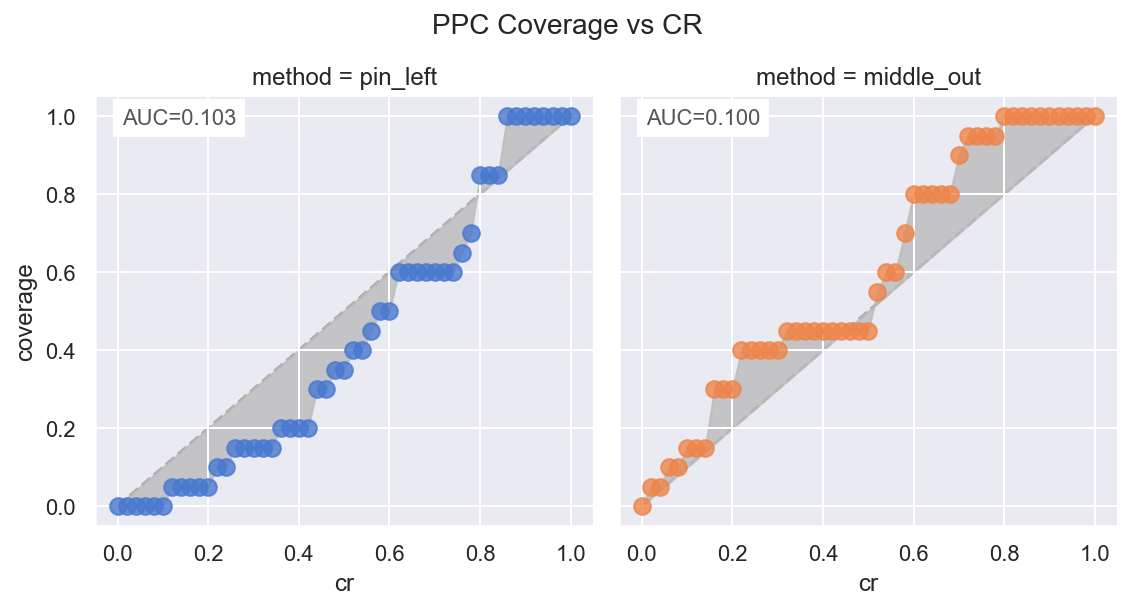

In [76]:
dfcov_m0 = mt.calc_ppc_coverage(y_m0, yhat[:, 0].T)
f = eda.plot_coverage(dfcov_m0)

**Observe:**

+ Looks pretty well-calibrated
+ AUC similar to ModelA0

#### 6.2.1.2: RMSE and R^2

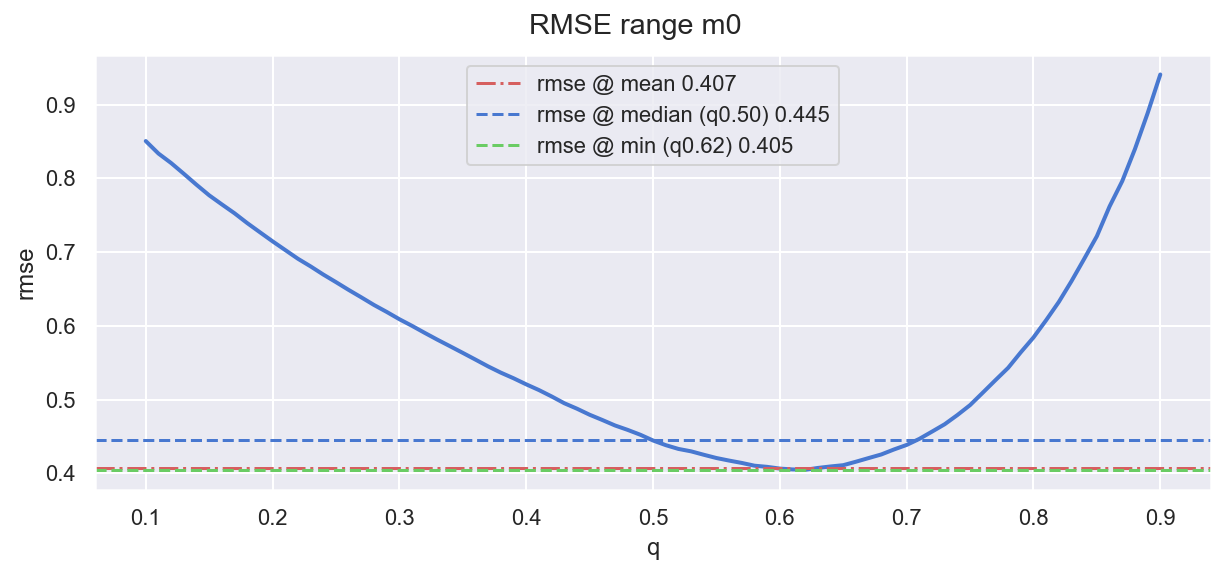

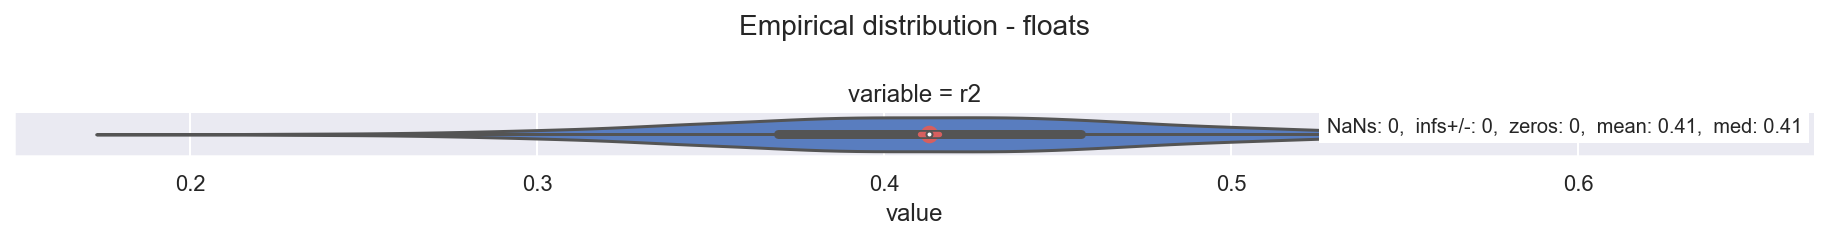

In [77]:
rmse, rmse_pct = mt.calc_rmse(y_m0, yhat[:, 0].T)
f = eda.plot_rmse_range(rmse, rmse_pct, yhat_name='m0')

r2 = mt.calc_bayesian_r2(y_m0, yhat[:, 0])
f = eda.plot_float_dist(r2, ['r2'], log=False)

**Observe:**

+ RMSE very similar to ModelA0
+ R^2 very similar to ModelA0 but variance is tighter

### 6.2.2 Margin M1

#### 6.2.2.1 Coverage

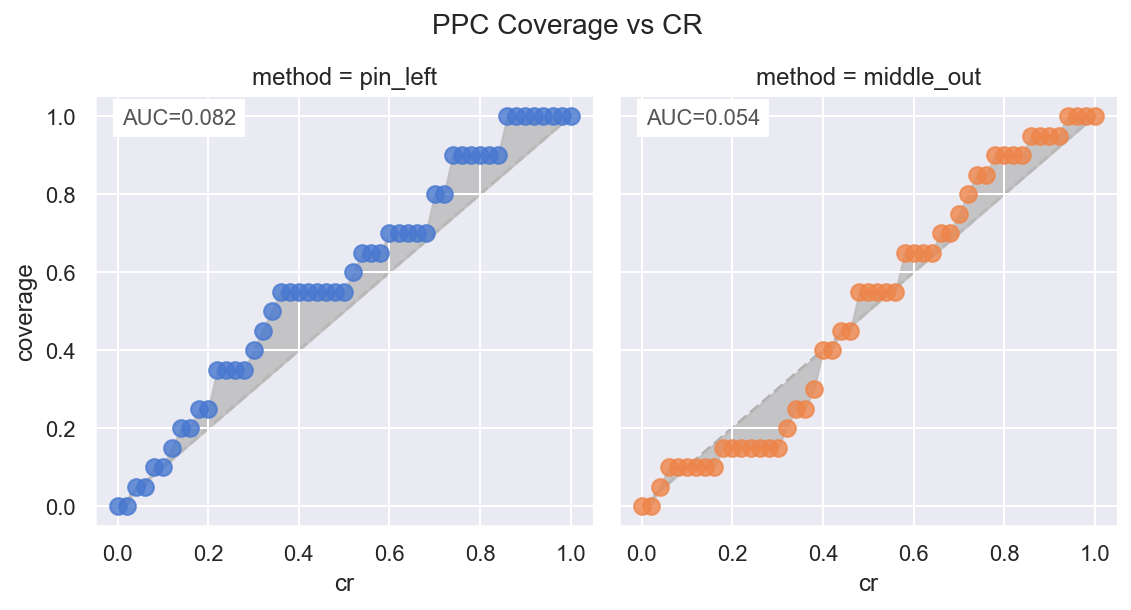

In [78]:
dfcov_m1 = mt.calc_ppc_coverage(y_m1, yhat[:, 1].T)
f = eda.plot_coverage(dfcov_m1)

**Observe:**

+ Also reasonably well-calibrated

#### 6.2.2.2: RMSE and R^2

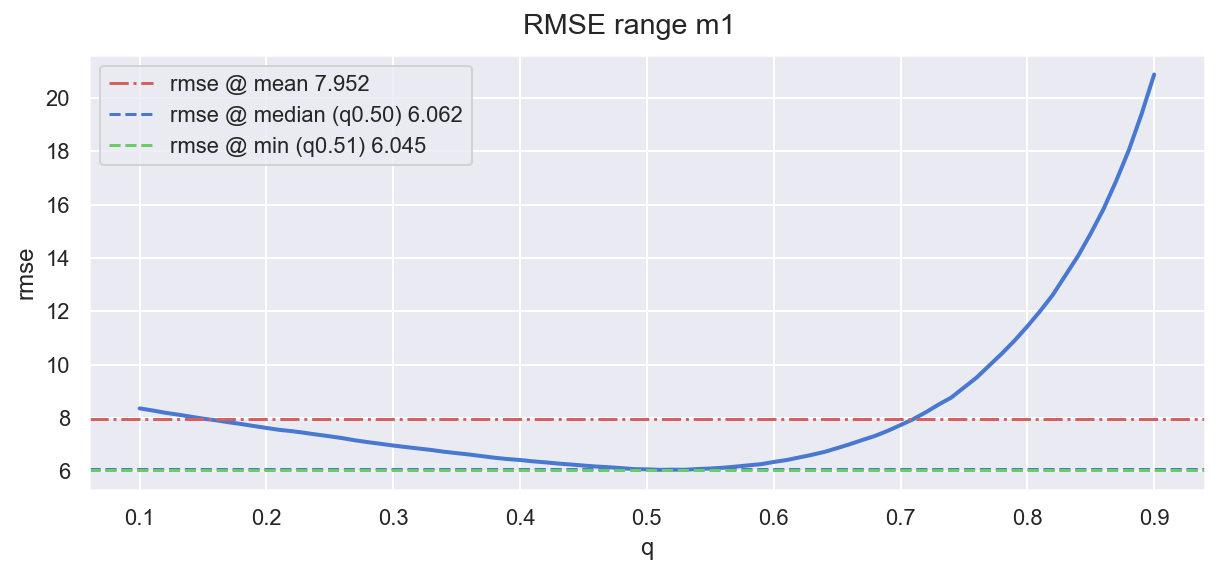

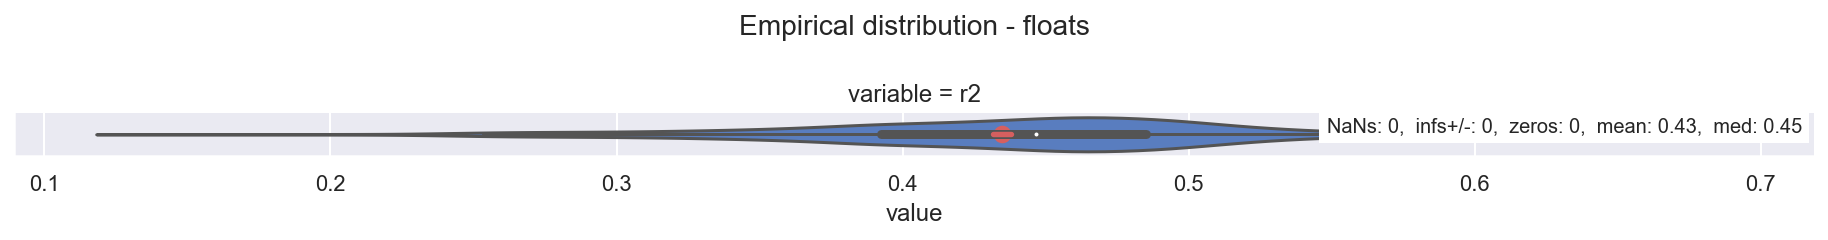

In [79]:
rmse, rmse_pct = mt.calc_rmse(y_m1, yhat[:, 1].T)
f = eda.plot_rmse_range(rmse, rmse_pct, yhat_name='m1')

r2 = mt.calc_bayesian_r2(y_m1, yhat[:, 1])
f = eda.plot_float_dist(r2, ['r2'], log=False)

**Observe:**

+ RMSE similar to ModelA0, but a little worse
+ R^2 very similar to ModelA0 

---

---

# Notes

In [80]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv -p pymc,pytensor

Author: jonathan.sedar@oreum.io

Last updated: 2024-07-04 16:01:38

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

pymc    : 5.9.2
pytensor: 2.17.3

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

oreum_core: 0.8.1
pandas    : 2.2.0
numpy     : 1.25.2
arviz     : 0.17.0
sys       : 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:38:07) [Clang 16.0.6 ]
seaborn   : 0.12.2



---
**Oreum OÜ &copy; 2024**